In [54]:
from core import *
from utils import *
from diagnostics import *
from fields import *
from constants import *
from distributions import *

from scipy import constants as sp
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numba import njit

import cProfile

def plot_traj(history):
    fig = plt.figure(figsize = plt.figaspect(1) * 7)
    ax = fig.add_subplot(111, projection='3d')

    for i in range(trials):
        pos = history[i, :, 0]
        ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])

    plt.show()
    
def plot_gca(gca):
    fig = plt.figure(figsize = plt.figaspect(1) * 7)
    ax = fig.add_subplot(111, projection='3d')

    for i in range(trials):
        pos = gca[i, :, :]
        ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])

    plt.show()
    
def to_percent(observed, actual):
    return abs((observed - actual) / actual) * 100

# Uniform Fields

### Nonrelativistic Velocities

By the definition of kinetic energy, a nonrelativistic particle should have a velocity that satisfies $\frac{1}{2}mv^2 = K$. Furthermore, the kinetic energy of a charged particle should not change when under the sole influence of a magnetic field. Therefore, we should find

$$v = \sqrt{\frac{2K_0}{m}},$$

where $K_0$ is the initial kinetic energy, for all points in time.

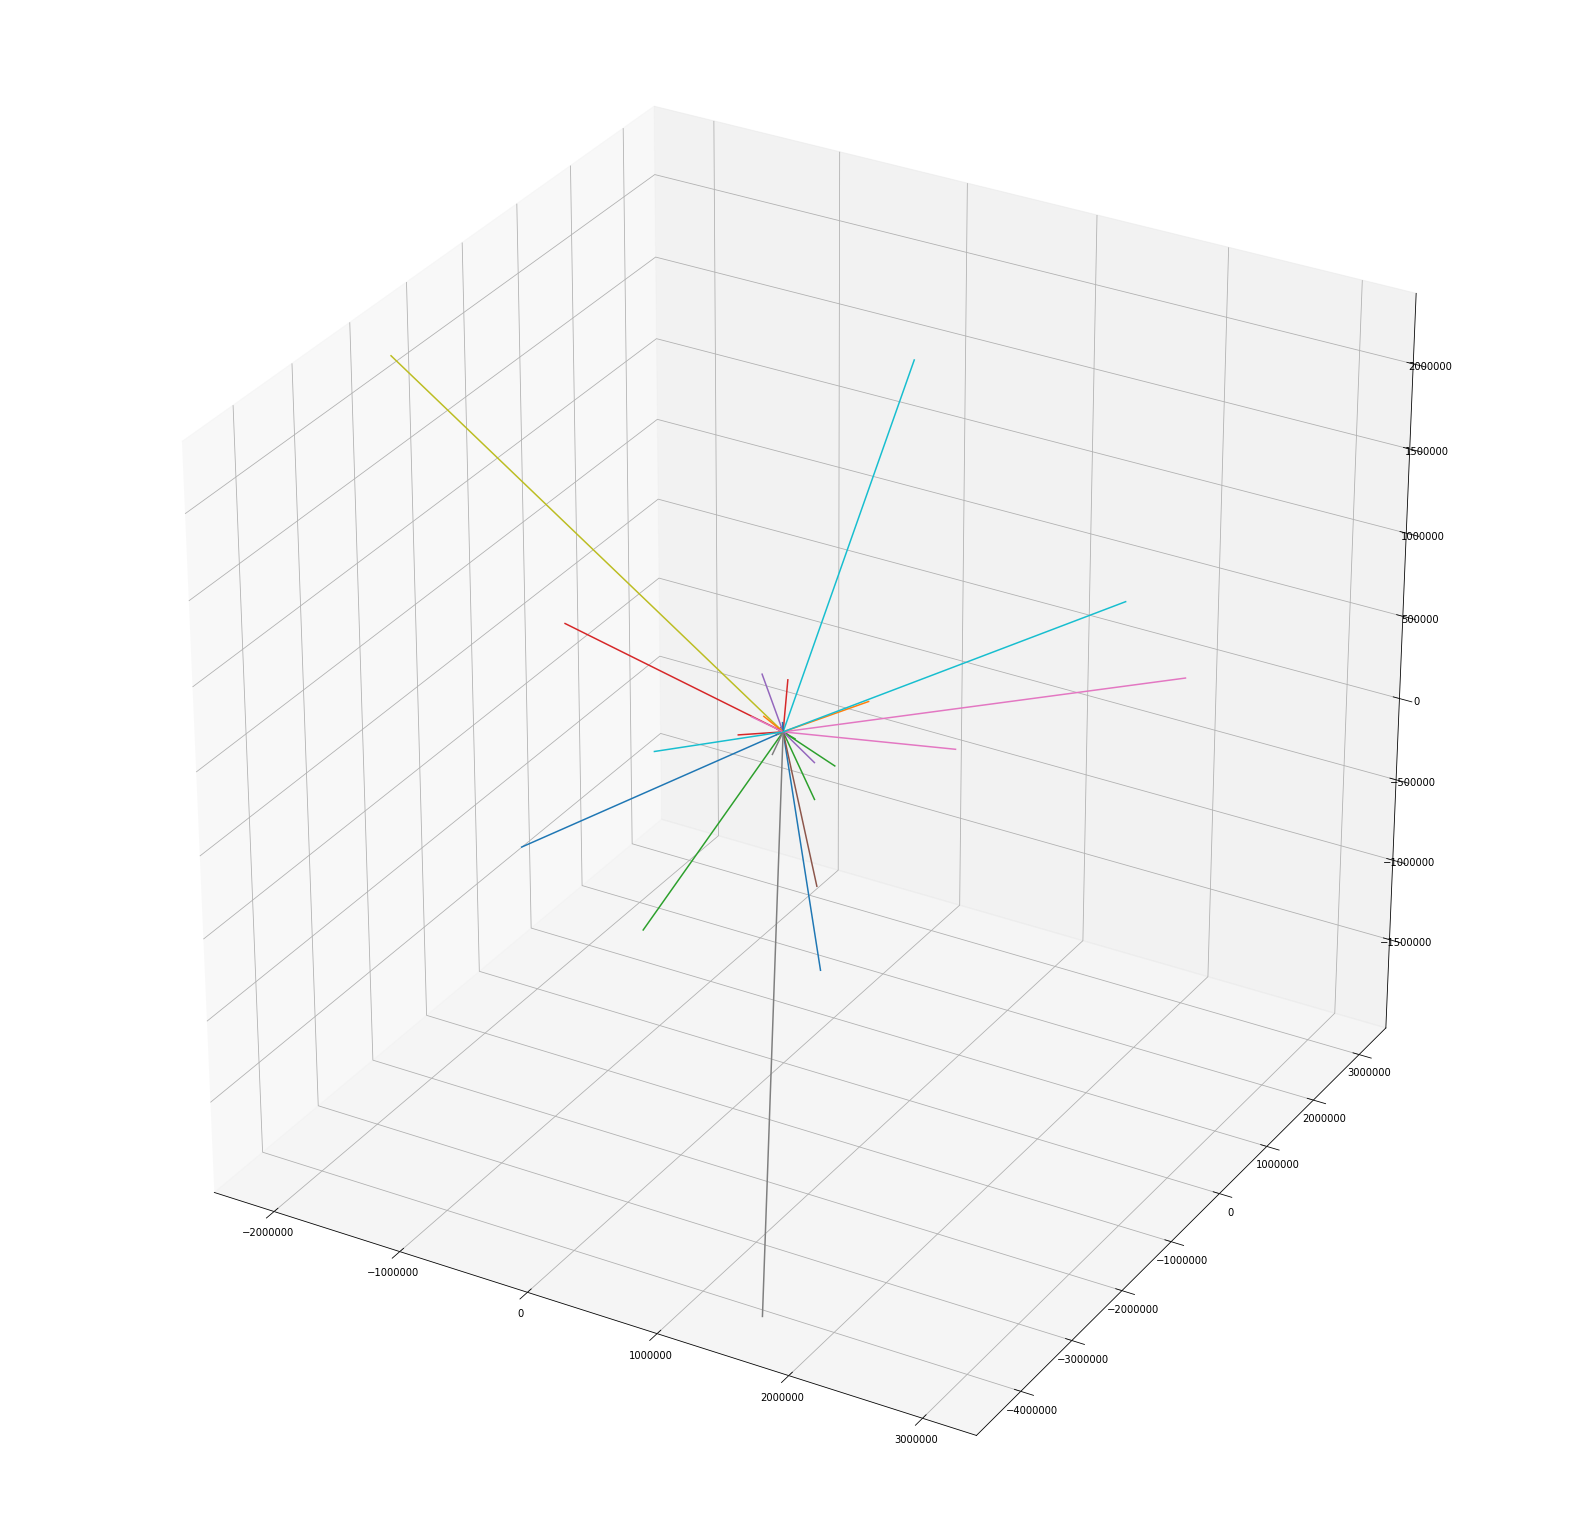

In [8]:
e_field = zero_field()
b_field = zero_field()
solve   = solver(nonrelativistic_boris(e_field, b_field))

T      = 1           # Total time (in seconds)
dt     = 1e-3        # Simulation time step
trials = 50          # Number of runs
steps  = int(T / dt) # Number of steps per run

history   = np.zeros((trials, steps, 4, 3)) # Particle, time slice, parameter (r, v, B, E), dimension
intrinsic = np.zeros((trials, 2))           # Particle, time slice, parameter (m, q)

# --------- #

def v_nonrel(K, m):
    return np.sqrt(2. * K / m)

analytical_v_nonrel = np.zeros(trials)

# --------- #

r_dist         = normal(0, 10, 3)
K_dist         = uniform_oom(-6, 2)
pitch_ang_dist = uniform(0, 1)
phase_ang_dist = uniform(0, 2 * np.pi)

for i in range(trials):
    r = r_dist()
    K = K_dist()
    
    history[i, 0, 0] = r
    history[i, 0, 1] = velocity_vec(r, K, sp.m_e, b_field, np.arccos(1 - 2 * pitch_ang_dist()), phase_ang_dist())
    history[i, 0, 2] = b_field(r)
    history[i, 0, 3] = e_field(r)
    intrinsic[i, 0]  = sp.m_e
    intrinsic[i, 1]  = -sp.e
    
    analytical_v_nonrel[i] = v_nonrel(eV_to_J(K), sp.m_e)
    
solve(history, intrinsic, dt)

plot_traj(history)

# --------- #

numerical_v_nonrel = np.asarray([np.sqrt(dot(k, k)) for k in history[:, -1, 1]])

In [9]:
# Nonrelativistic velocity results
error = to_percent(numerical_v_nonrel, analytical_v_nonrel)

# print('Error (%): ' + ' '.join(f'{x:.2f}\n' for x in error))
print(f'Average Error (%): {np.mean(error):.2f}')

Average Error (%): 0.00


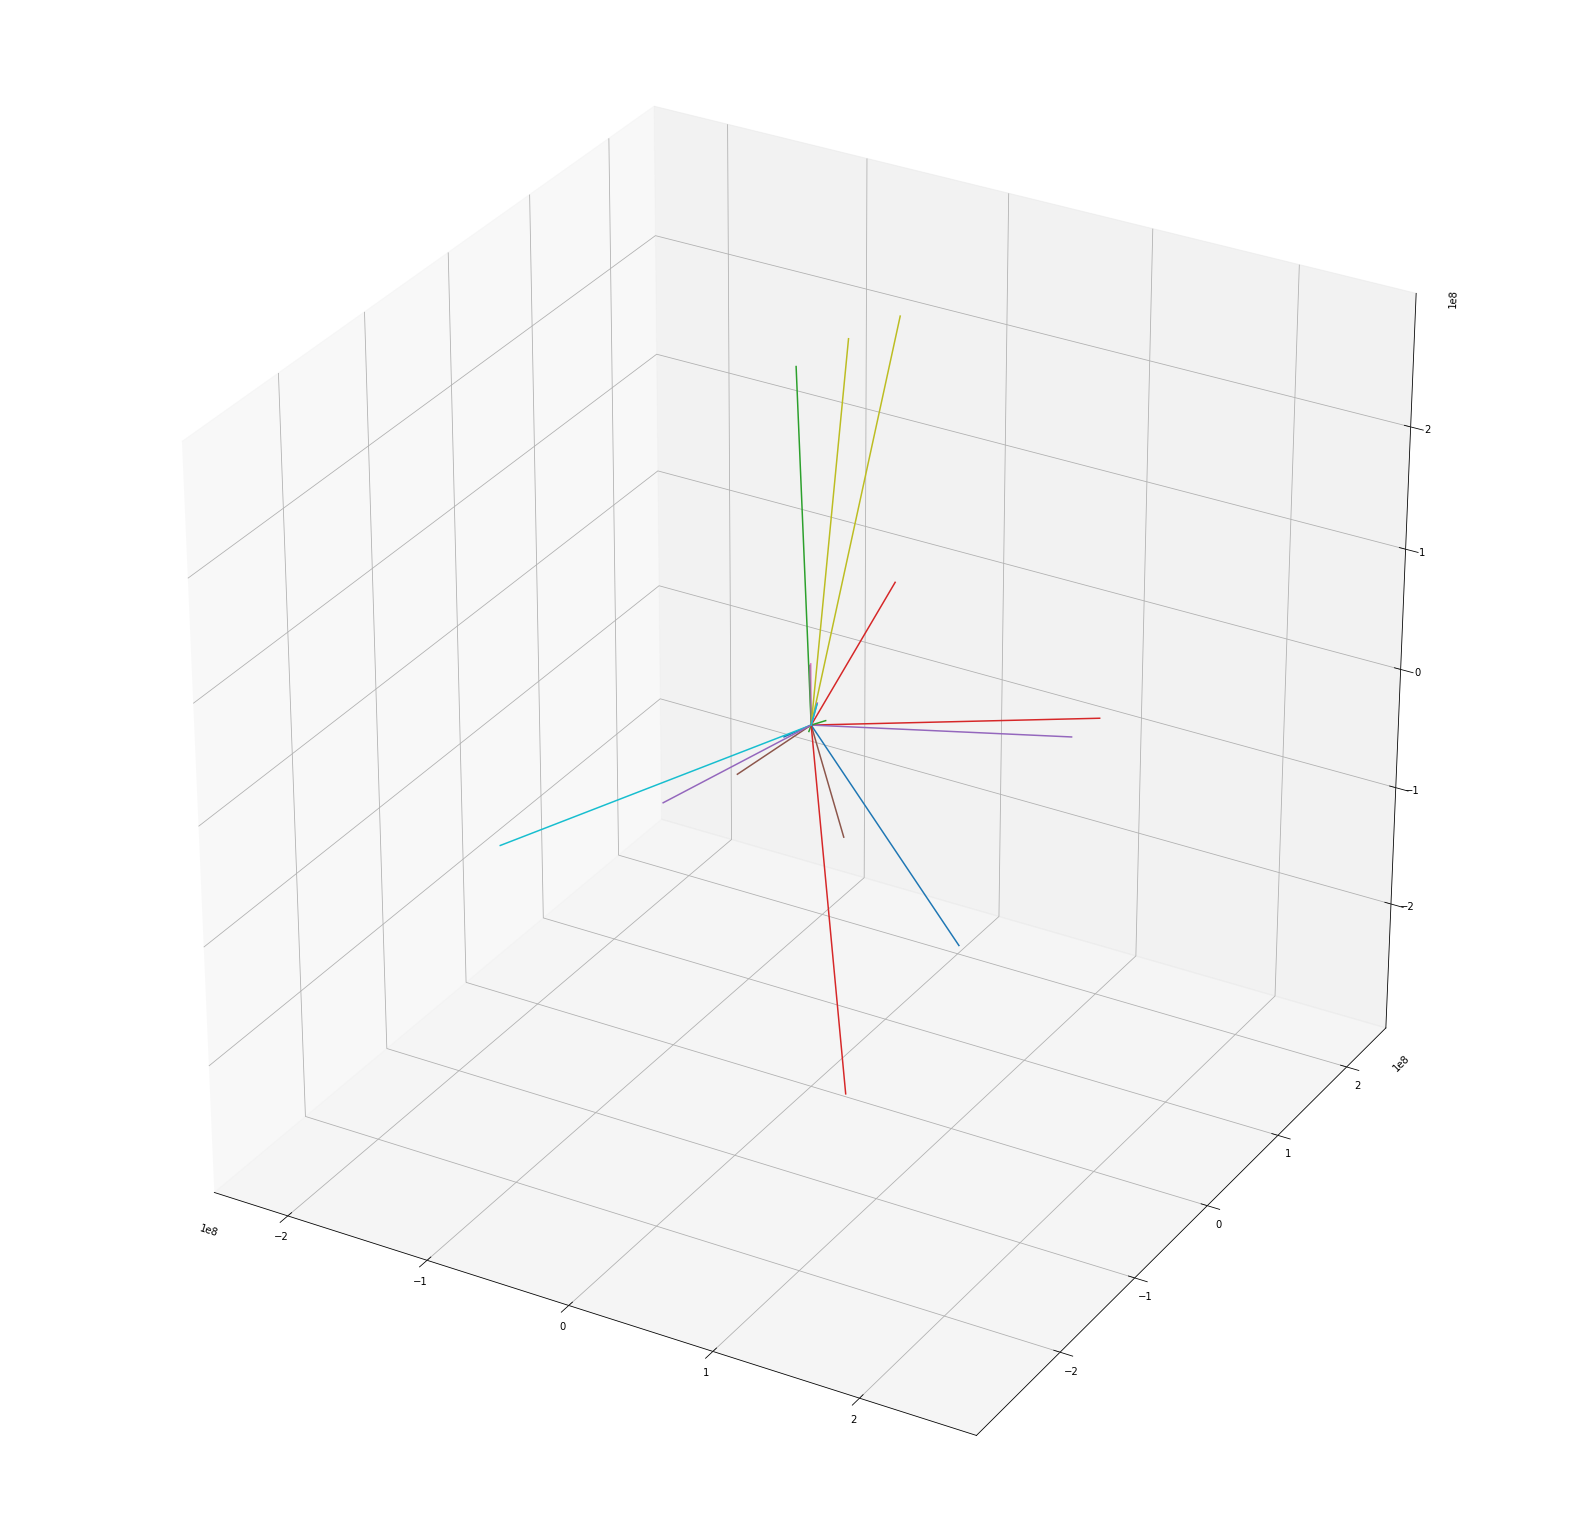

In [6]:
e_field = zero_field()
b_field = zero_field()
solve   = solver(relativistic_boris(e_field, b_field))

T      = 1           # Total time (in seconds)
dt     = 1e-3        # Simulation time step
trials = 50          # Number of runs
steps  = int(T / dt) # Number of steps per run

history   = np.zeros((trials, steps, 4, 3)) # Particle, time slice, parameter (r, v, B, E), dimension
intrinsic = np.zeros((trials, 2))           # Particle, time slice, parameter (m, q)

# --------- #

def gamma_from_E(K, m):
    return 1 + K / (m * sp.c**2)

def v_rel(g):
    return (sp.c / g) * sqrt(g**2 - 1)

analytical_v_rel = np.zeros(trials)

# --------- #

r_dist         = normal(0, 10, 3)
K_dist         = uniform_oom(-6, 7)
pitch_ang_dist = uniform(0, 1)
phase_ang_dist = uniform(0, 2 * np.pi)

for i in range(trials):
    r = r_dist()
    K = K_dist()
    
    history[i, 0, 0] = r
    history[i, 0, 1] = velocity_vec(r, K, sp.m_e, b_field, np.arccos(1 - 2 * pitch_ang_dist()), phase_ang_dist())
    history[i, 0, 2] = b_field(r)
    history[i, 0, 3] = e_field(r)
    intrinsic[i, 0]  = sp.m_e
    intrinsic[i, 1]  = -sp.e
    
    analytical_v_rel[i] = v_rel(gamma_from_E(eV_to_J(K), sp.m_e))
    
solve(history, intrinsic, dt)

plot_traj(history)

# --------- #

numerical_v_rel = np.asarray([np.sqrt(dot(k, k)) for k in history[:, -1, 1]])

In [7]:
# Relativistic velocity results
error = to_percent(numerical_v_rel, analytical_v_rel)

# print('Error (%): ' + ' '.join(f'{x:.2f}\n' for x in error))
print(f'Average Error (%): {np.mean(error):.2f}')

Average Error (%): 0.00


### Nonrelativistic Gyrofrequency and Gyroradius

The gyroradius of a nonrelativistic charged particle may be found by combining the requirement for circular motion,

$$F = \frac{mv_{\perp}^2}{r},$$

with the Lorentz force in the case of a zero electric field,

$$\mathbf{F} = q\mathbf{v}\times\mathbf{B} \to F = |q|v_{\perp}B.$$

Solving for $r$ yields

$$r = \frac{mv_{\perp}}{|q|B}.$$

From this, we can get the gyrofrequency by setting $\omega r = v_{\perp}$, i.e.

$$\omega = \frac{|q|B}{m}.$$

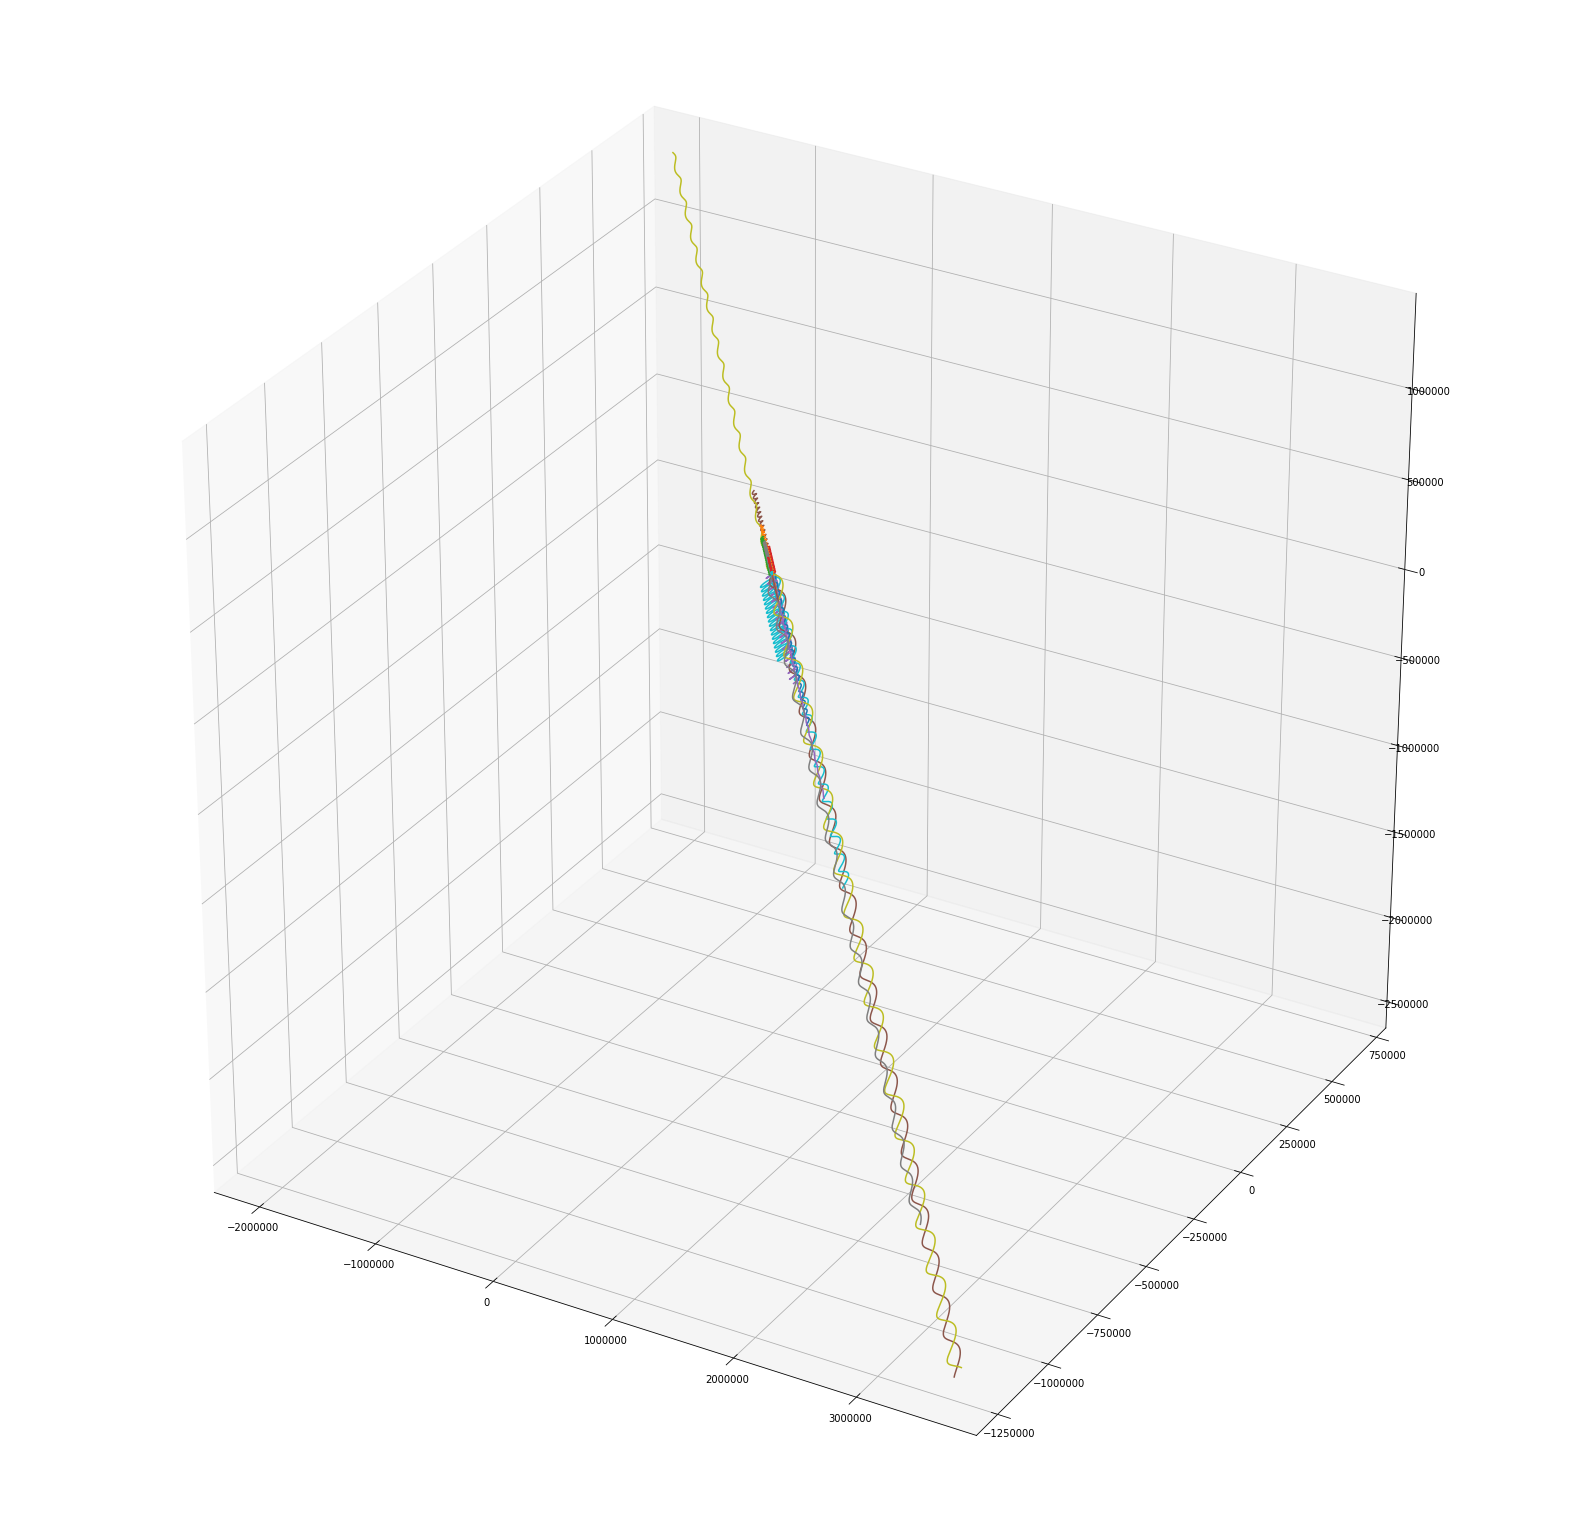

In [22]:
b_strength_dist = uniform_oom(-10, -8)
b_axis_dist     = normal(0, 1, 3)

e_field = zero_field()
b_field = uniform_field(b_strength_dist(), b_axis_dist())
solve   = solver(nonrelativistic_boris(e_field, b_field))

T      = 1           # Total time (in seconds)
dt     = 1e-5        # Simulation time step
trials = 50          # Number of runs
steps  = int(T / dt) # Number of steps per run

history   = np.zeros((trials, steps, 4, 3)) # Particle, time slice, parameter (r, v, B, E), dimension
intrinsic = np.zeros((trials, 2))           # Particle, time slice, parameter (m, q)
    
# --------- #    

def gyrofreq_nonrel(m, q, B):
    return abs(q) * np.linalg.norm(B) / m

def gyrorad_nonrel(m, q, B, v):
    v_perp = np.linalg.norm(v - (np.dot(v, B) / np.dot(B, B)) * B)
    return m * v_perp / (abs(q) * np.linalg.norm(B))

analytical_gyrofreq_nonrel = np.zeros(trials)
analytical_gyrorad_nonrel = np.zeros(trials)

# --------- #

r_dist         = normal(0, 10, 3)
K_dist         = uniform_oom(-6, 2)
pitch_ang_dist = uniform(0, 1)
phase_ang_dist = uniform(0, 2 * np.pi)

for i in range(trials):
    r = r_dist()
    K = K_dist()
    
    history[i, 0, 0] = r
    history[i, 0, 1] = velocity_vec(r, K, sp.m_e, b_field, np.arccos(1 - 2 * pitch_ang_dist()), phase_ang_dist())
    history[i, 0, 2] = b_field(r)
    history[i, 0, 3] = e_field(r)
    intrinsic[i, 0]  = sp.m_e
    intrinsic[i, 1]  = -sp.e
    
    analytical_gyrofreq_nonrel[i] = gyrofreq_nonrel(sp.m_e, -sp.e, history[i, 0, 2])
    analytical_gyrorad_nonrel[i]  = gyrorad_nonrel(sp.m_e, -sp.e, history[i, 0, 2], history[i, 0, 1])
    
solve(history, intrinsic, dt)

plot_traj(history)

# --------- #   

numerical_gyrofreq_nonrel = gyrofreq(history, intrinsic)
numerical_gyrorad_nonrel  = gyrorad(history, intrinsic)

In [23]:
# Nonrelativistic gyrofrequency results
error = to_percent(numerical_gyrofreq_nonrel[:, -1], analytical_gyrofreq_nonrel)

# print('Error (%): ' + ' '.join(f'{x:.2f}\n' for x in error))
print(f'Average Error (%): {np.mean(error):.2f}')

Average Error (%): 0.00


In [24]:
# Nonrelativistic gyroradius results
error = to_percent(numerical_gyrorad_nonrel[:, -1], analytical_gyrorad_nonrel)

# print('Error (%): ' + ' '.join(f'{x:.2f}\n' for x in error))
print(f'Average Error (%): {np.mean(error):.2f}')

Average Error (%): 0.00


### Relativistic Gyrofrequency and Gyroradius

The Lorentz force is already covariant, so we simply need to change the centripetal force requirement in our previous derivation. We can enforce compatibility with relativity by expressing it in the terms of momentum and taking the relativistic definition,

$$F = \frac{p_{\perp}^2}{mr} = \frac{\gamma m v_{\perp}^2}{r}.$$

This altered requirement corrects the gyroradius and gyrofrequency expressions to read

$$r = \frac{\gamma m v_{\perp}}{|q|B}$$

and

$$\omega = \frac{|q|B}{\gamma m}.$$

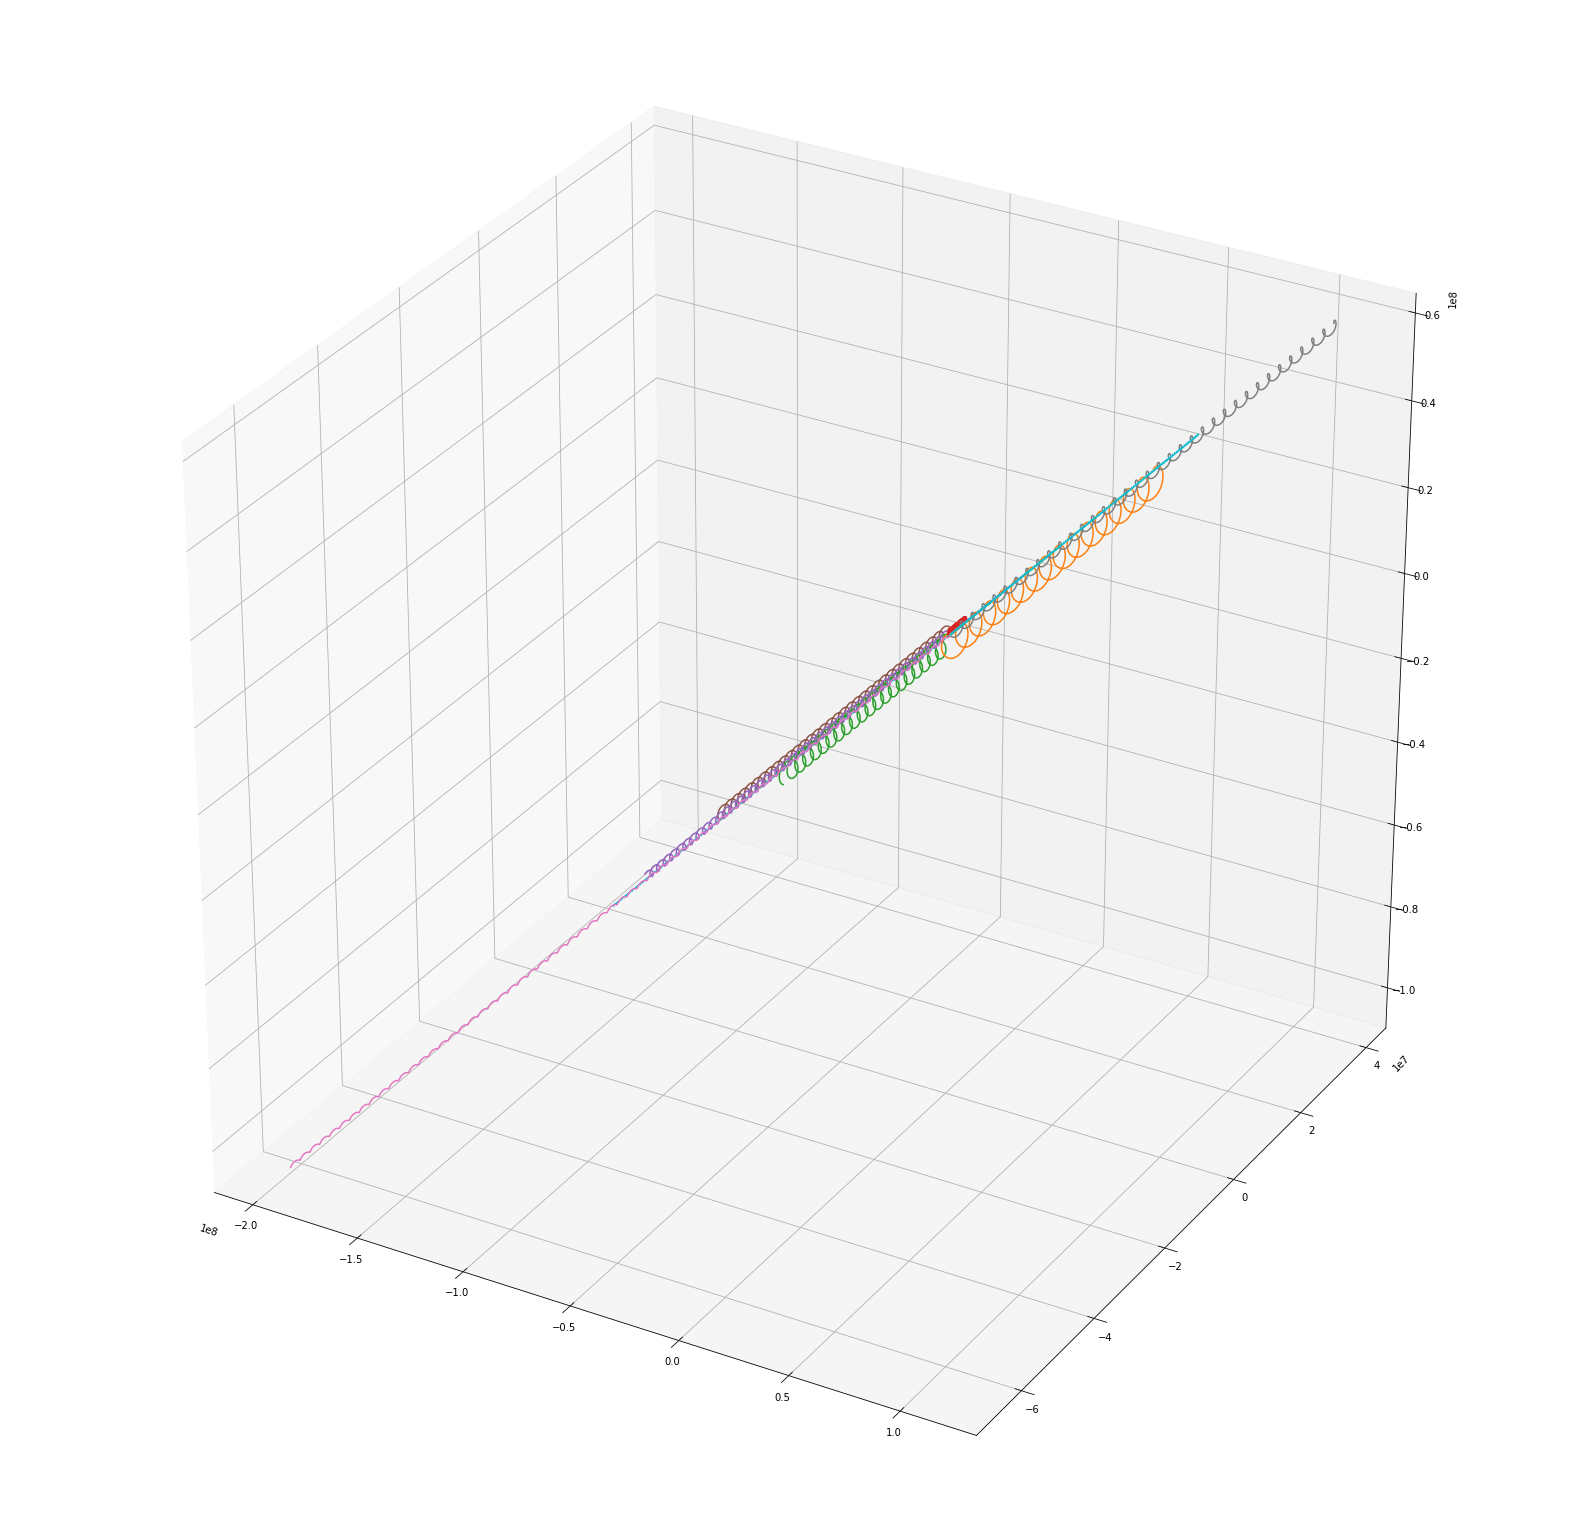

In [25]:
b_strength_dist = uniform_oom(-10, -8)
b_axis_dist     = normal(0, 1, 3)

e_field = zero_field()
b_field = uniform_field(b_strength_dist(), b_axis_dist())
solve   = solver(relativistic_boris(e_field, b_field))

T      = 1           # Total time (in seconds)
dt     = 1e-5        # Simulation time step
trials = 50          # Number of runs
steps  = int(T / dt) # Number of steps per run

history   = np.zeros((trials, steps, 4, 3)) # Particle, time slice, parameter (r, v, B, E), dimension
intrinsic = np.zeros((trials, 2))           # Particle, time slice, parameter (m, q)
    
# --------- #    

def gyrofreq_rel(m, q, B, g):
    return (abs(q) * np.linalg.norm(B)) / (g * m)

def gyrorad_rel(m, q, B, v, g):
    v_perp = np.linalg.norm(v - (np.dot(v, B) / np.dot(B, B)) * B)
    return (g * m * v_perp) / (abs(q) * np.linalg.norm(B))

analytical_gyrofreq_rel = np.zeros(trials)
analytical_gyrorad_rel = np.zeros(trials)

# --------- #

r_dist         = normal(0, 10, 3)
K_dist         = uniform_oom(-6, 7)
pitch_ang_dist = uniform(0, 1)
phase_ang_dist = uniform(0, 2 * np.pi)

for i in range(trials):
    r = r_dist()
    K = K_dist()
    
    history[i, 0, 0] = r
    history[i, 0, 1] = velocity_vec(r, K, sp.m_e, b_field, np.arccos(1 - 2 * pitch_ang_dist()), phase_ang_dist())
    history[i, 0, 2] = b_field(r)
    history[i, 0, 3] = e_field(r)
    intrinsic[i, 0]  = sp.m_e
    intrinsic[i, 1]  = -sp.e
    
    analytical_gyrofreq_rel[i] = gyrofreq_rel(sp.m_e, -sp.e, history[i, 0, 2], gamma(history[i, 0, 1]))
    analytical_gyrorad_rel[i]  = gyrorad_rel(sp.m_e, -sp.e, history[i, 0, 2], history[i, 0, 1], gamma(history[i, 0, 1]))
    
solve(history, intrinsic, dt)

plot_traj(history)

# --------- #   

numerical_gyrofreq_rel = gyrofreq(history, intrinsic)
numerical_gyrorad_rel  = gyrorad(history, intrinsic)

In [27]:
# Relativistic gyrofrequency results
error = to_percent(numerical_gyrofreq_rel[:, -1], analytical_gyrofreq_rel)

# print('Error (%): ' + ' '.join(f'{x:.2f}\n' for x in error))
print(f'Average Error (%): {np.mean(error):.2f}')

Average Error (%): 0.00


In [28]:
# Relativistic gyroradius results
error = to_percent(numerical_gyrorad_rel[:, -1], analytical_gyrorad_rel)

# print('Error (%): ' + ' '.join(f'{x:.2f}\n' for x in error))
print(f'Average Error (%): {np.mean(error):.2f}')

Average Error (%): 0.00


### Nonrelativistic $\mathbf{E} \times \mathbf{B}$ Drift

As a charged particle moves through a region containing both an electric and magnetic field, its gyration is altered in such a way so as to produce a drift orthogonal to both. In a plasma, an electric field parallel to the magnetic field is difficult to sustain (with electrons redistributing themselves so as to nullify the effect), so we consider only orthogonal fields below.

Given the Lorentz force, we may average over one gyroperiod and cross both sides with $\mathbf{B}/B^2$ to find

\begin{align}
m\frac{\mathrm{d}\langle\mathbf{v}\rangle}{\mathrm{d}t}\times\frac{\mathbf{B}}{B^2} &= q\Big(\mathbf{E} + \langle\mathbf{v}\rangle\times\mathbf{B}\Big)\times\frac{\mathbf{B}}{B^2} \\
\frac{m}{qB^2}\frac{\mathrm{d}\big(\langle\mathbf{v}\rangle \times \mathbf{B}\big)}{\mathrm{d}t} &= \frac{\mathbf{E}\times\mathbf{B}}{B^2} + \frac{\langle\mathbf{v}\rangle\cdot\mathbf{B}}{B^2}\mathbf{B} - \langle\mathbf{v}\rangle \\
-\frac{m}{qB^2}\frac{\mathrm{d}\mathbf{E}}{\mathrm{d}t} &= \frac{\mathbf{E}\times\mathbf{B}}{B^2} - \langle\mathbf{v}_{\perp}\rangle \\
\langle\mathbf{v}_{\perp}\rangle &= \frac{\mathbf{E}\times\mathbf{B}}{B^2} + \frac{m}{qB^2}\frac{\mathrm{d}\mathbf{E}}{\mathrm{d}t}
\end{align}

where $\mathbf{v}_{\perp}$ is the velocity perpendicular to the magnetic field and we have replaced $\mathbf{v}\times\mathbf{B}$ with $-\mathbf{E}$ by considering the Lorentz transformation to the guiding center's frame of motion.

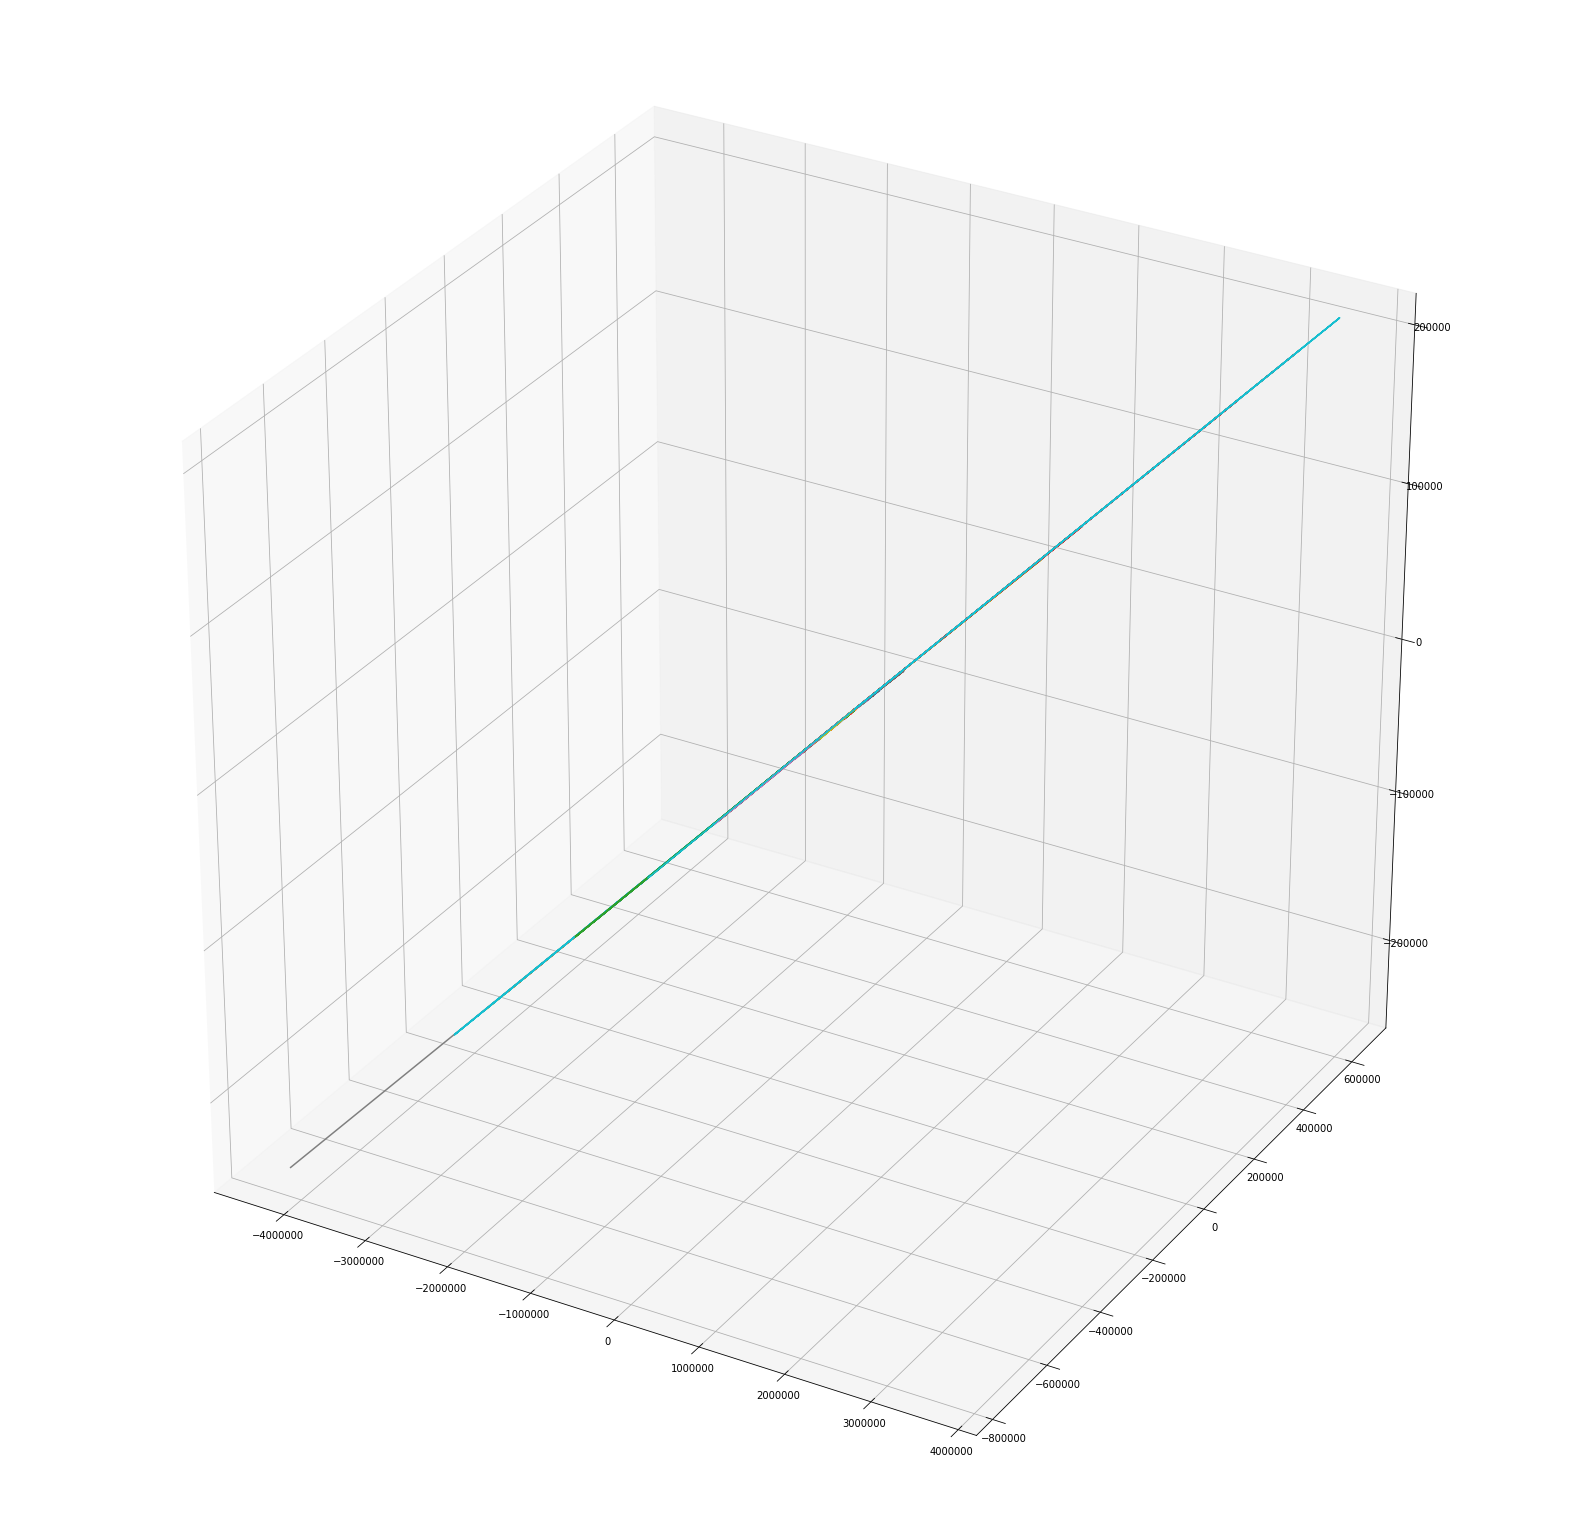

In [44]:
b_axis_dist = normal(0, 1, 3)
e_axis_dist = normal(0, 1, 3)

b_axis = b_axis_dist()
e_axis = e_axis_dist()
e_axis = e_axis - np.dot(e_axis, b_axis) * b_axis / np.dot(b_axis, b_axis)

e_field = uniform_field(1e-3, e_axis)
b_field = uniform_field(1e-6, b_axis)
solve   = solver(nonrelativistic_boris(e_field, b_field))

T      = 1           # Total time (in seconds)
dt     = 1e-5        # Simulation time step
trials = 50          # Number of runs
steps  = int(T / dt) # Number of steps per run

history   = np.zeros((trials, steps, 4, 3)) # Particle, time slice, parameter (r, v, B, E), dimension
intrinsic = np.zeros((trials, 2))           # Particle, time slice, parameter (m, q)
    
# --------- #    

origin = np.zeros(3)
drift_vel = np.cross(e_field(origin), b_field(origin)) / np.dot(b_field(origin), b_field(origin))
analytical_drift_nonrel = np.zeros((trials, 3))

# --------- #

r_dist         = normal(0, 10, 3)
K_dist         = uniform_oom(-2, 2)
pitch_ang_dist = uniform(0, 1)
phase_ang_dist = uniform(0, 2 * np.pi)

for i in range(trials):
    r = r_dist()
    K = K_dist()
    
    history[i, 0, 0] = r
    history[i, 0, 1] = velocity_vec(r, K, sp.m_e, b_field, np.arccos(1 - 2 * pitch_ang_dist()), phase_ang_dist())
    history[i, 0, 2] = b_field(r)
    history[i, 0, 3] = e_field(r)
    intrinsic[i, 0]  = sp.m_e
    intrinsic[i, 1]  = -sp.e
    
    analytical_drift_nonrel[i] = np.dot(history[i, 0, 1], history[i, 0, 2]) * history[i, 0, 2] / np.dot(history[i, 0, 2], history[i, 0, 2]) + drift_vel
    
solve(history, intrinsic, dt)

plot_traj(history)

# --------- # 

frames = 1000
guiding_center = gca(history, intrinsic, dt)
numerical_drift_nonrel = (guiding_center[:, -1] - guiding_center[:, -frames]) / (frames * dt)

In [46]:
# E x B drift results
error = to_percent(np.array(numerical_drift_nonrel), np.array(analytical_drift_nonrel))

# print('Error (%): ' + ' '.join(f'{x:.2f}\n' for x in error))
print(f'Average Error (%): {np.mean(error):.2f}')

Average Error (%): 0.10


### Relativistic $\mathbf{E} \times \mathbf{B}$ Drift

The relativistic $\mathbf{E}\times\mathbf{B}$ is more complicated for a particle traveling in an arbitrary direction. In particular, when

$$\frac{\mathbf{E}\times\mathbf{B}}{B^2} > c$$

the drift velocity is no longer well defined and the particle undergoes continual acceleration as detailed in https://doi.org/10.1103/PhysRevE.66.037402. From a computational perspective, relativistic $\mathbf{E}\times\mathbf{B}$ drift poses problems because the relativistic Boris integrator is energy conserving only when there is a vanishing $\mathbf{E}$ field. We may have to implement a different relativistic integrator if we wish to investigate these conditions.

# Dipolar Fields

### Nonrelativistic Loss Cone and Mirror Point

We cannot find an arbitrary analytical solution for the trajectory of a charged particle in a dipole field, so we must instead compare numerical results with analytic ones for certain measurable parameters. We know that, for particles trapped by a dipole magnetic field, their bounce point is determined by

$$\sin^2(\theta_0) = \frac{B_0}{B_m}$$

where $\theta_0$ is the equatorial pitch angle, $B_0$ is the magnetic field at the midplane, and $B_m$ is the magnetic field at the bounce point.

The solver has the inbuilt ability to calculate the equatorial pitch angle of a particle (assuming the equatorial plane coincides with $z = 0$). Finding the relevant magnetic field values for cross-checking is not as straightforward as it may appear because these values are defined at the *guiding center* of the particle. Because this simulation's eventual goal is to reliably represent nonadiabatic scattering, implementing a true guiding center approximation may not be productive. Instead, a simple filter is applied to the particle's trajectory with its cutoff frequency a decade below the slowest measured gyrofrequency (which is also technically measured at the particle's guiding center, but is approximated by computing it at the particle's true location).

With this approximate guiding center, we can find the midplane magnetic field value the same way we found the equatorial pitch angle (see the code), while tracking the maximum magnetic field value by looking for local extrema in the guiding center trajectory.

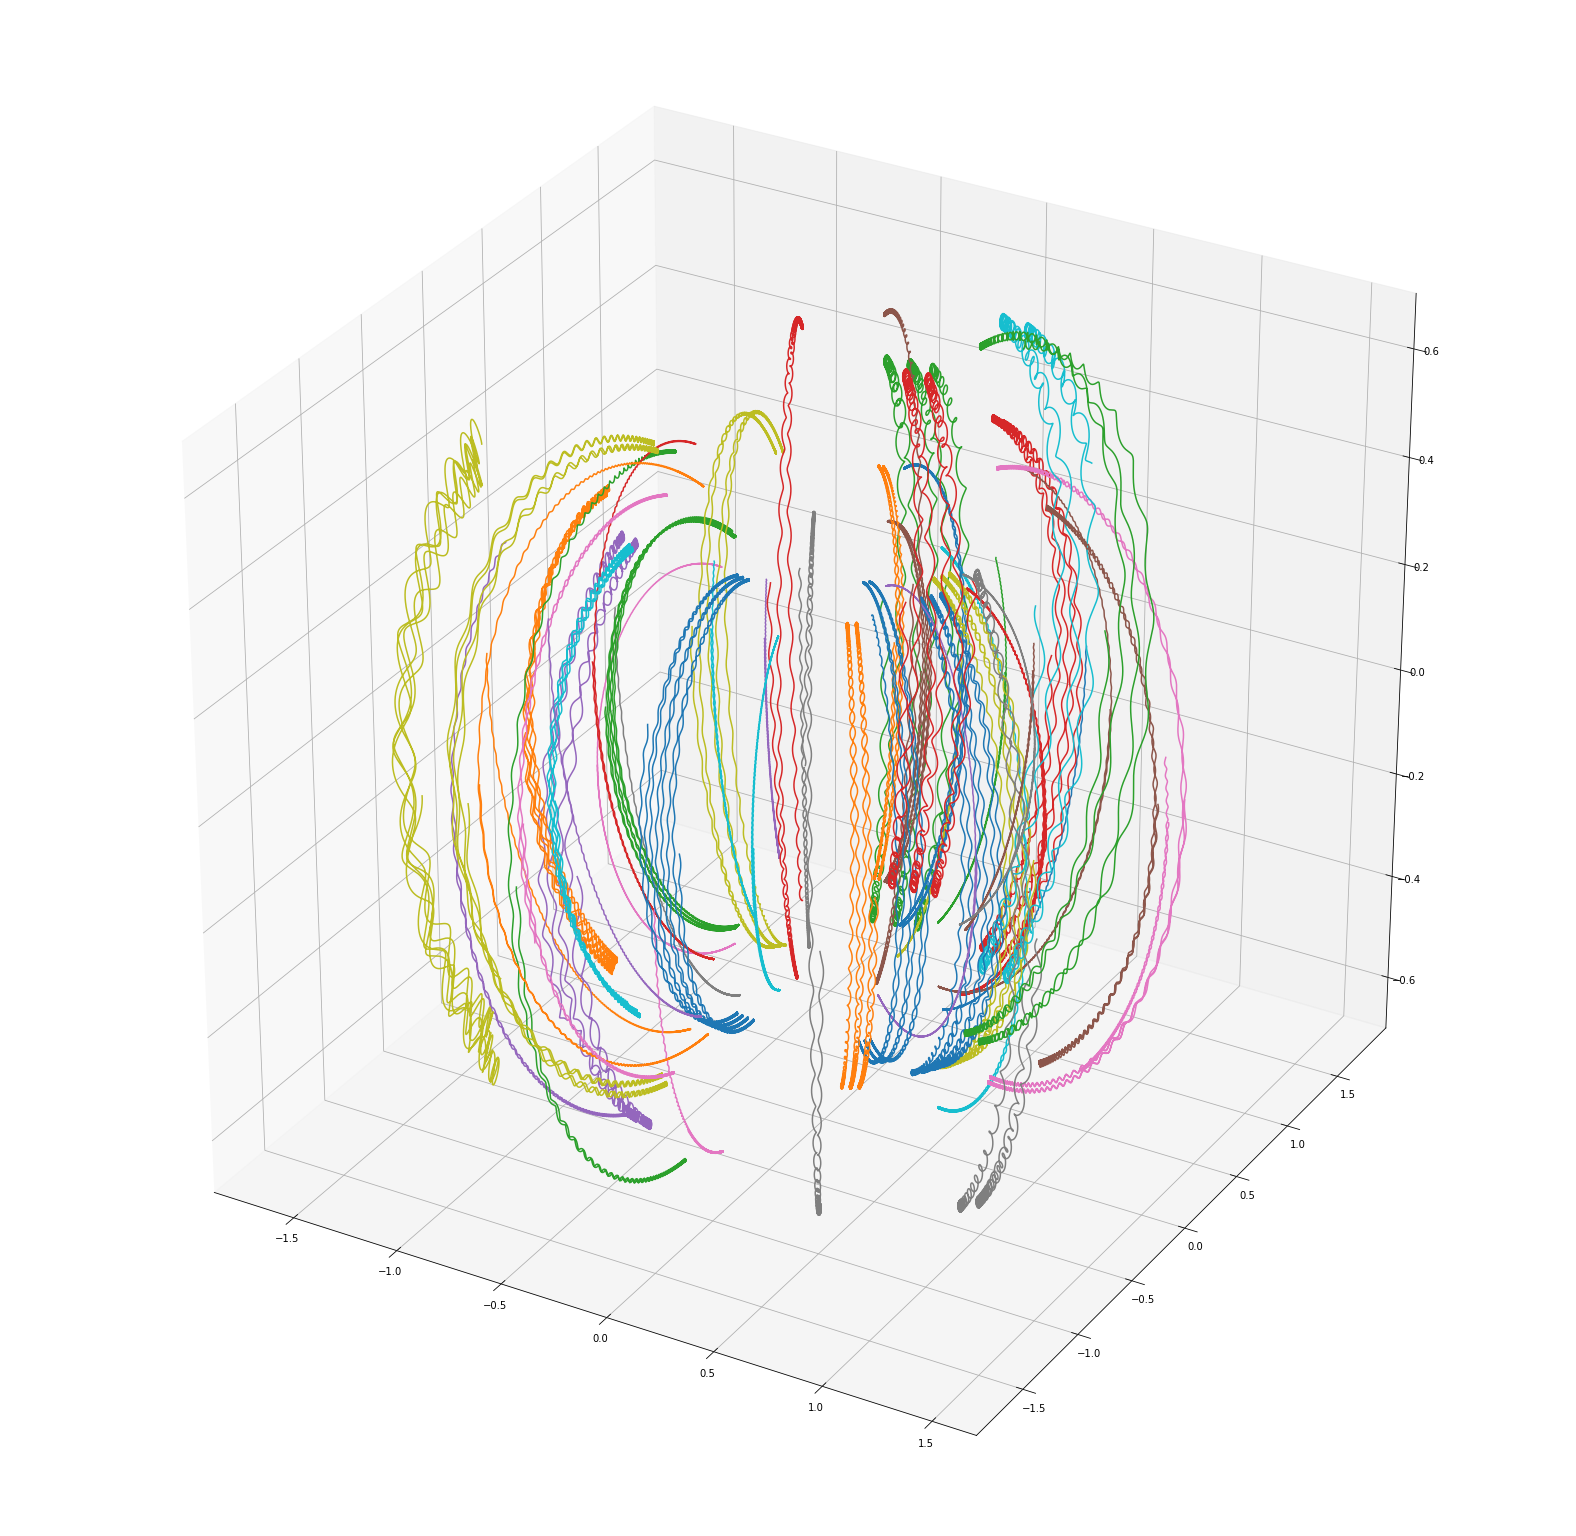

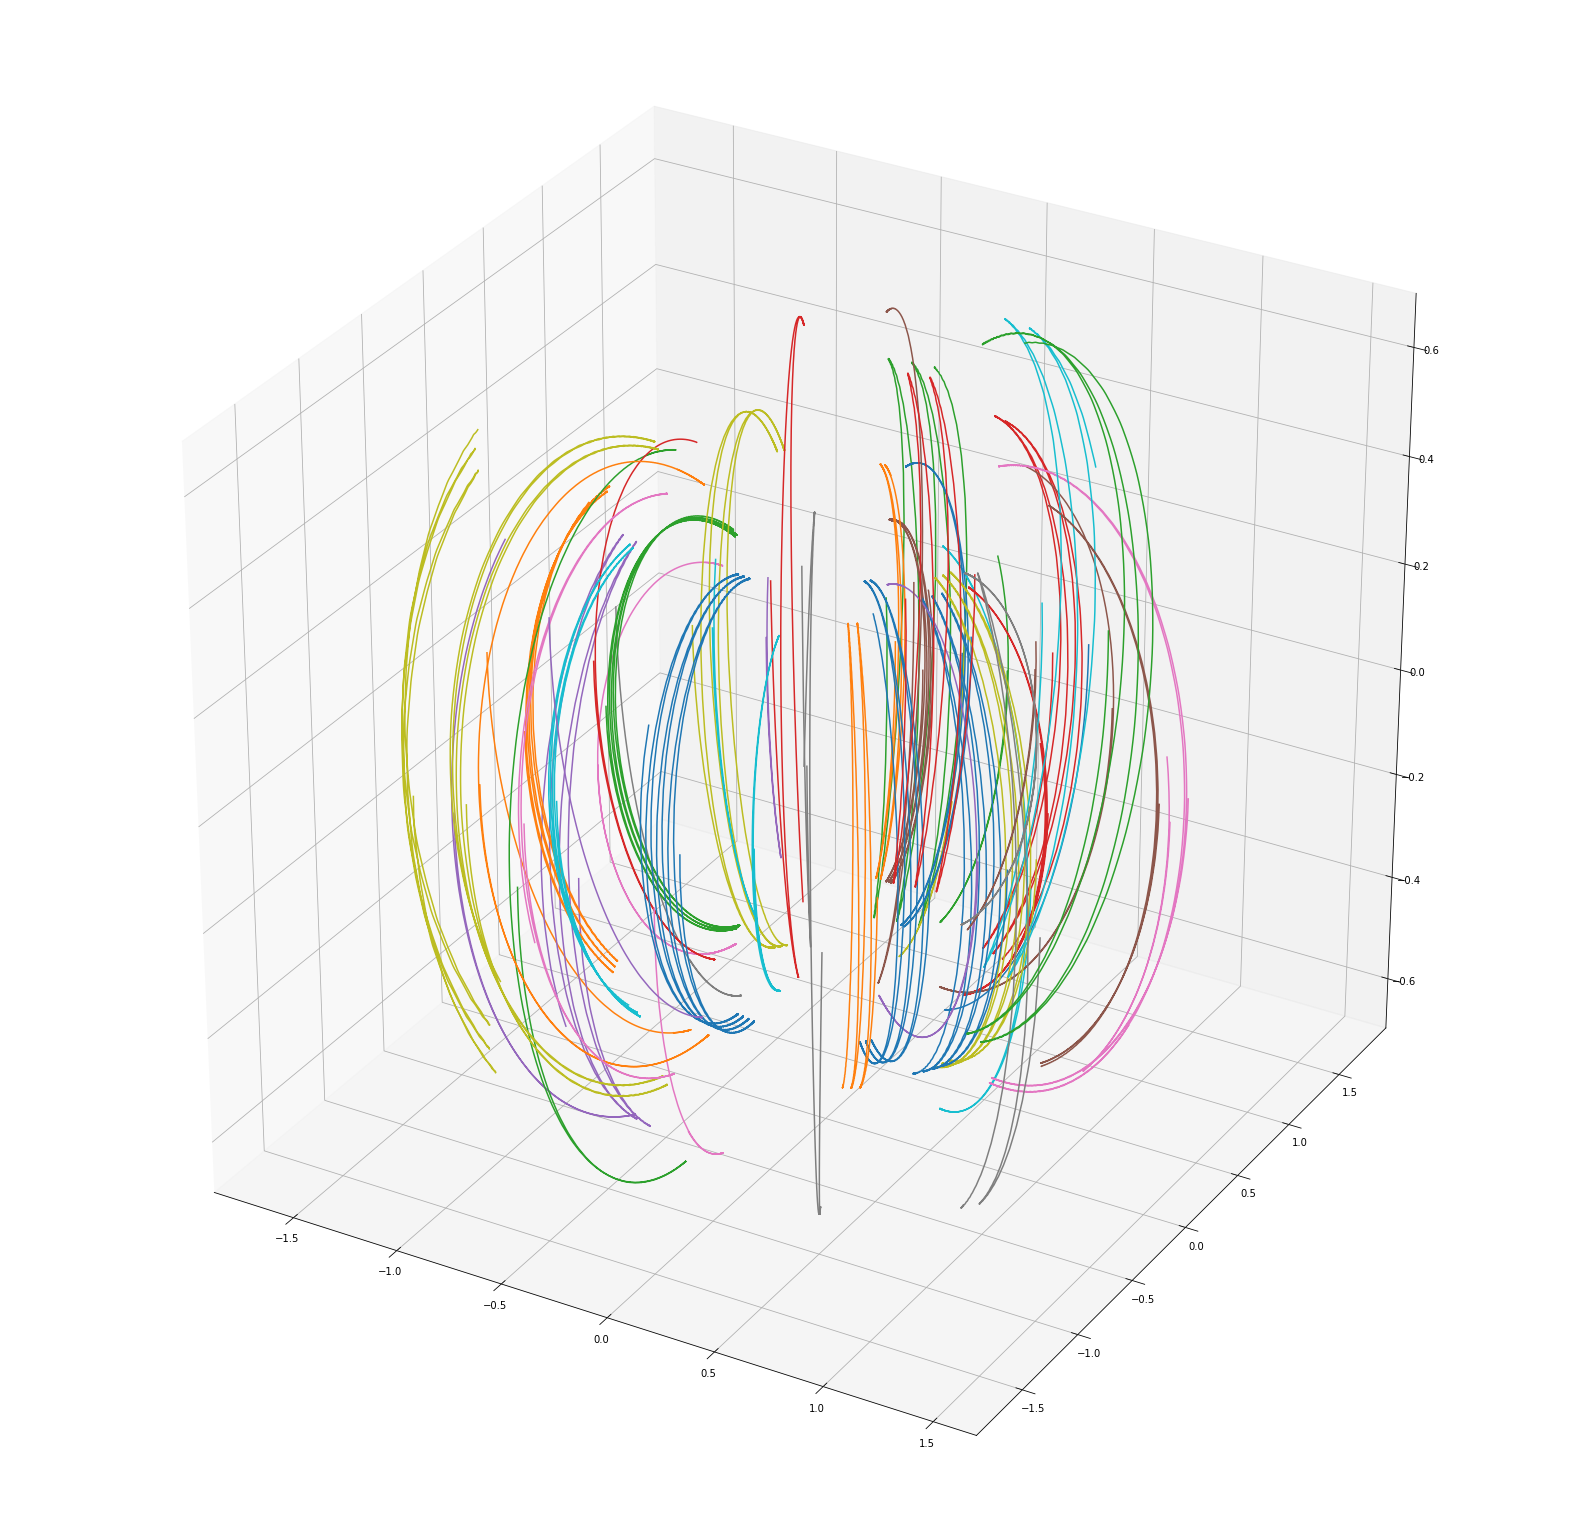

In [49]:
e_field = zero_field()
b_field = magnetic_dipole(10.0, np.array([0., 0., 1.]))
solve   = solver(nonrelativistic_boris(e_field, b_field))

T      = 1e-2          # Total time (in seconds)
dt     = 1e-6        # Simulation time step
trials = 50          # Number of runs
steps  = int(T / dt) # Number of steps per run

history   = np.zeros((trials, steps, 4, 3)) # Particle, time slice, parameter (r, v, B, E), dimension
intrinsic = np.zeros((trials, 2))           # Particle, time slice, parameter (m, q)
    
# --------- #    

@njit
def gca_pos_mag(gca):
    history_new = np.zeros(len(gca[:, 0]))

    for i in range(len(gca[:, 0])):
        history_new[i] = np.sqrt(dot(gca[i], gca[i]))
    
    return history_new

def B_max(gca, B):
    z = gca[:, 2]
    
    # Find the local extrema of the z-path traced by the guiding center
    indices = np.argwhere(np.r_[True, z[1:] < z[:-1]] & np.r_[z[:-1] < z[1:], True] == True)[:, 0]
    
    # Find the magnitude of the magnetic field at the bounce points. This is where the particle is closest to the origin
    gca_mag = gca_pos_mag(gca)
    index = np.argwhere(gca_mag == np.amin(gca_mag))[:, 0][0]
    
    return np.linalg.norm(B(gca[index]))
    
def B_min(gca, B):
    z = gca[:, 2]
    
    # Find the indices marking the zero crossings of the guiding center trajectory
    z_sign = np.sign(z)
    rolled_z = np.roll(z_sign, 1) - z_sign
    
    # Remove the first crossing (usually anomalous)
    rolled_z[0] = 0
    indices = np.argwhere(rolled_z != 0)[:, 0]

    # Track the magnitude of the magnetic field at the equatorial plane via linear interpolation
    positions = []
    for i in indices:
        t = -gca[i - 1, 2] * dt / (gca[i, 2] - gca[i - 1, 2])
        positions.append((gca[i, :] - gca[i - 1, :]) / dt * t + gca[i - 1, :])
    B_min = [np.linalg.norm(B(r)) for r in positions]
    
    # Average over the values
    return np.sum(B_min) / len(B_min)

def loss_cone_from_B(B_min, B_max):
    return np.degrees(np.arcsin(np.sqrt(B_min / B_max)))

analytical_loss_cone_nonrel = np.zeros(trials)

# --------- #

r_dist         = uniform_ring(0.75, 1.75)
K_dist         = uniform_oom(-7, -5)
pitch_ang_dist = uniform(np.pi / 12, np.pi / 4)
phase_ang_dist = uniform(0, 2 * np.pi)

for i in range(trials):
    r = r_dist()
    K = K_dist()
    
    history[i, 0, 0] = r
    history[i, 0, 1] = velocity_vec(r, K, sp.m_e, b_field, pitch_ang_dist(), phase_ang_dist())
    history[i, 0, 2] = b_field(r)
    history[i, 0, 3] = e_field(r)
    intrinsic[i, 0]  = sp.m_e
    intrinsic[i, 1]  = -sp.e
        
solve(history, intrinsic, dt)

plot_traj(history)

guiding_center = gca_nonrel(history, intrinsic)
plot_gca(guiding_center)

# --------- #   

eq_pas = eq_pitch_angle(history)
numerical_loss_cone_nonrel = np.zeros(trials)

for i in range(trials):
    numerical_loss_cone_nonrel[i]  = np.mean(eq_pas[i, np.nonzero(eq_pas[i, :])])
    analytical_loss_cone_nonrel[i] = loss_cone_from_B(B_min(guiding_center[i], b_field), B_max(guiding_center[i], b_field))

In [50]:
# Nonrelativistic loss cone results
error = to_percent(numerical_loss_cone_nonrel, analytical_loss_cone_nonrel)

# print('Error (%): ' + ' '.join(f'{x:.2f}\n' for x in error))
print(f'Average Error (%): {np.mean(error):.2f}')

Average Error (%): 1.21


### Relativistic Loss Cone and Mirror Point

Beyond simply applying the above test to the case of relativistic particles, we can further probe the validity of the simulation by examining relativistic corrections to the loss cone. As detailed in https://doi.org/10.1002/2014GL061869, relativistic particles instantiated in the midplane of a dipole field exhibit a loss cone dependent on the azimuthal angle the velocity vector makes with the magnetic field. This fine structure in velocity space is tested below.

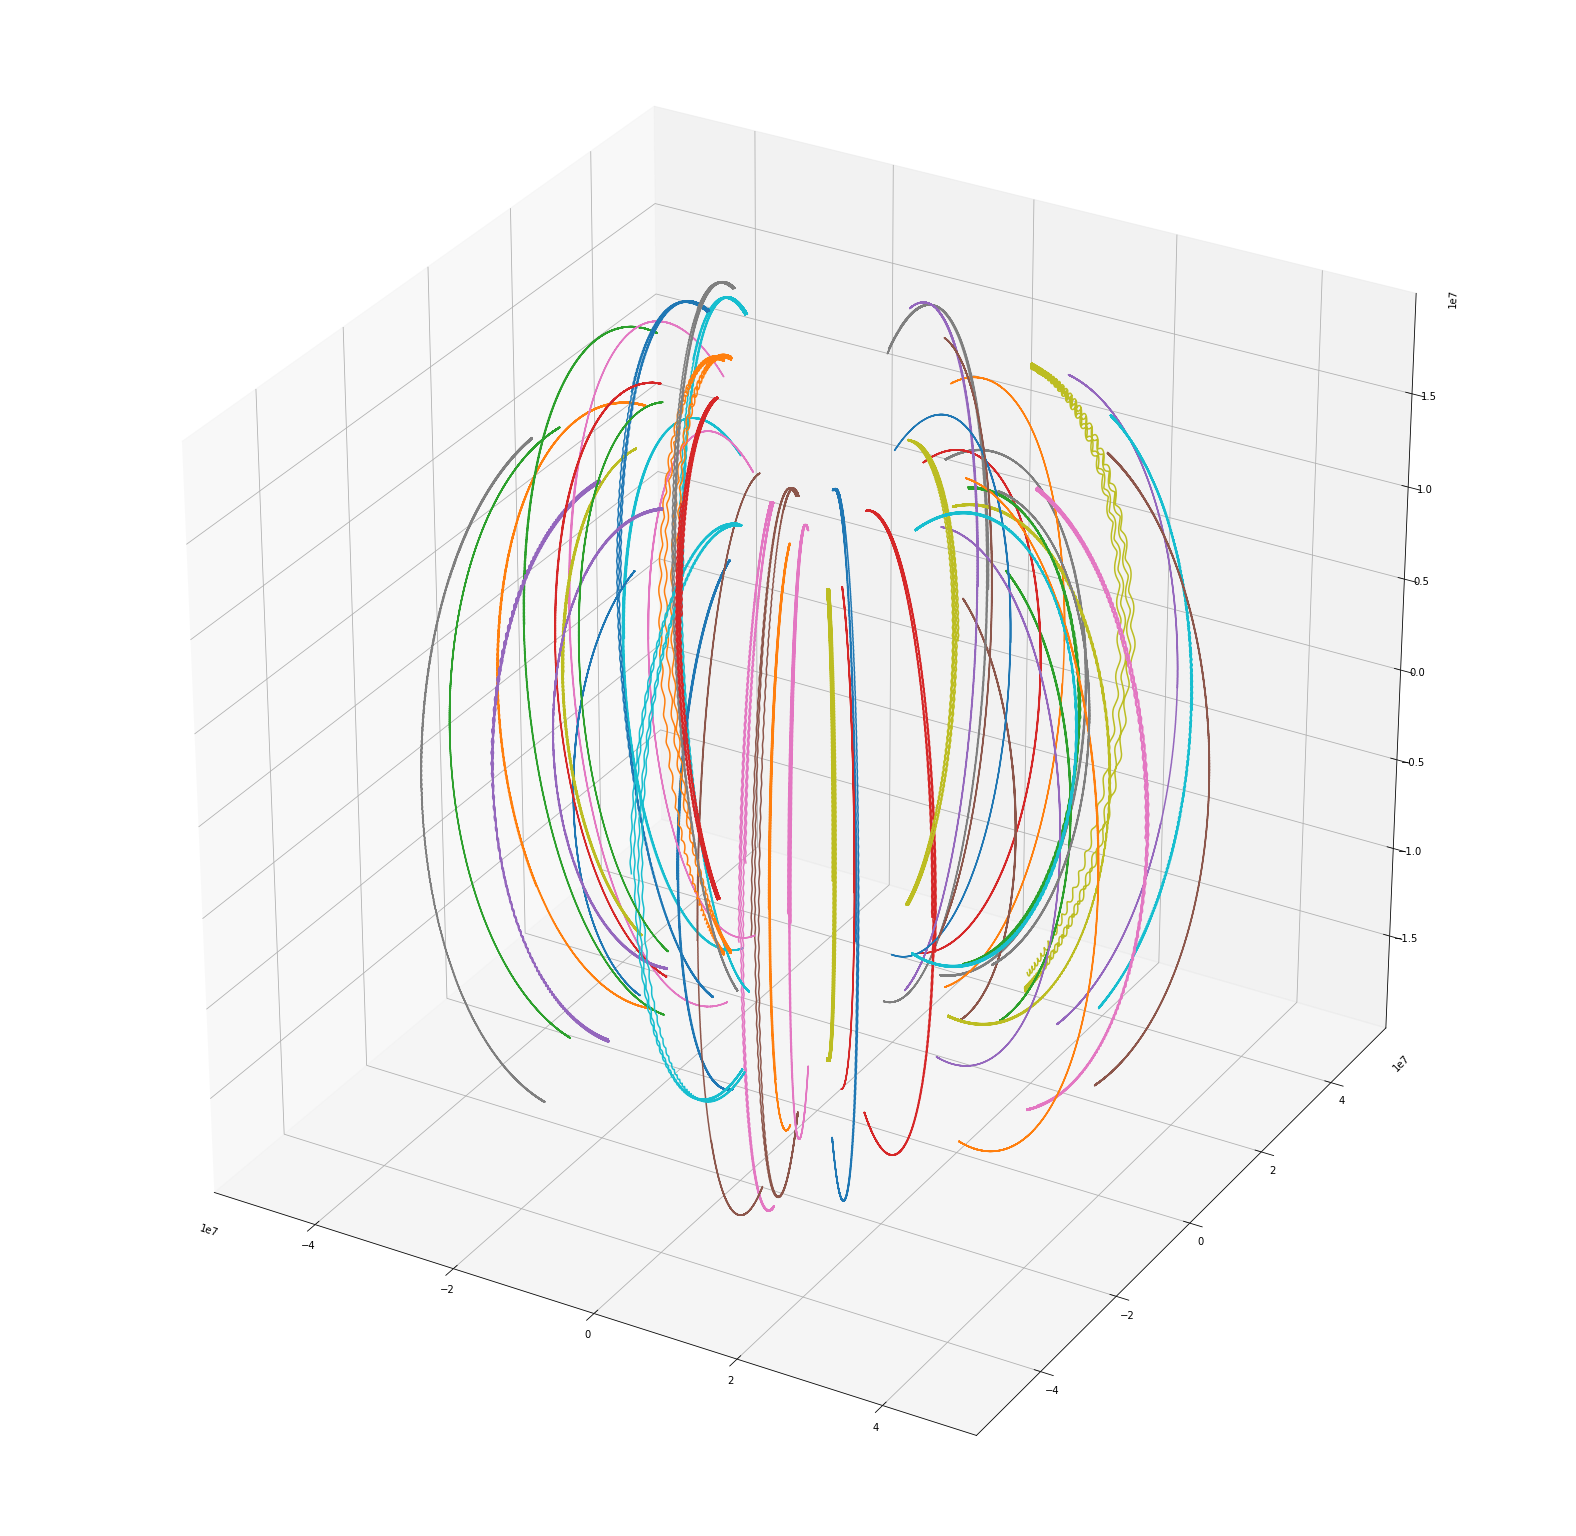

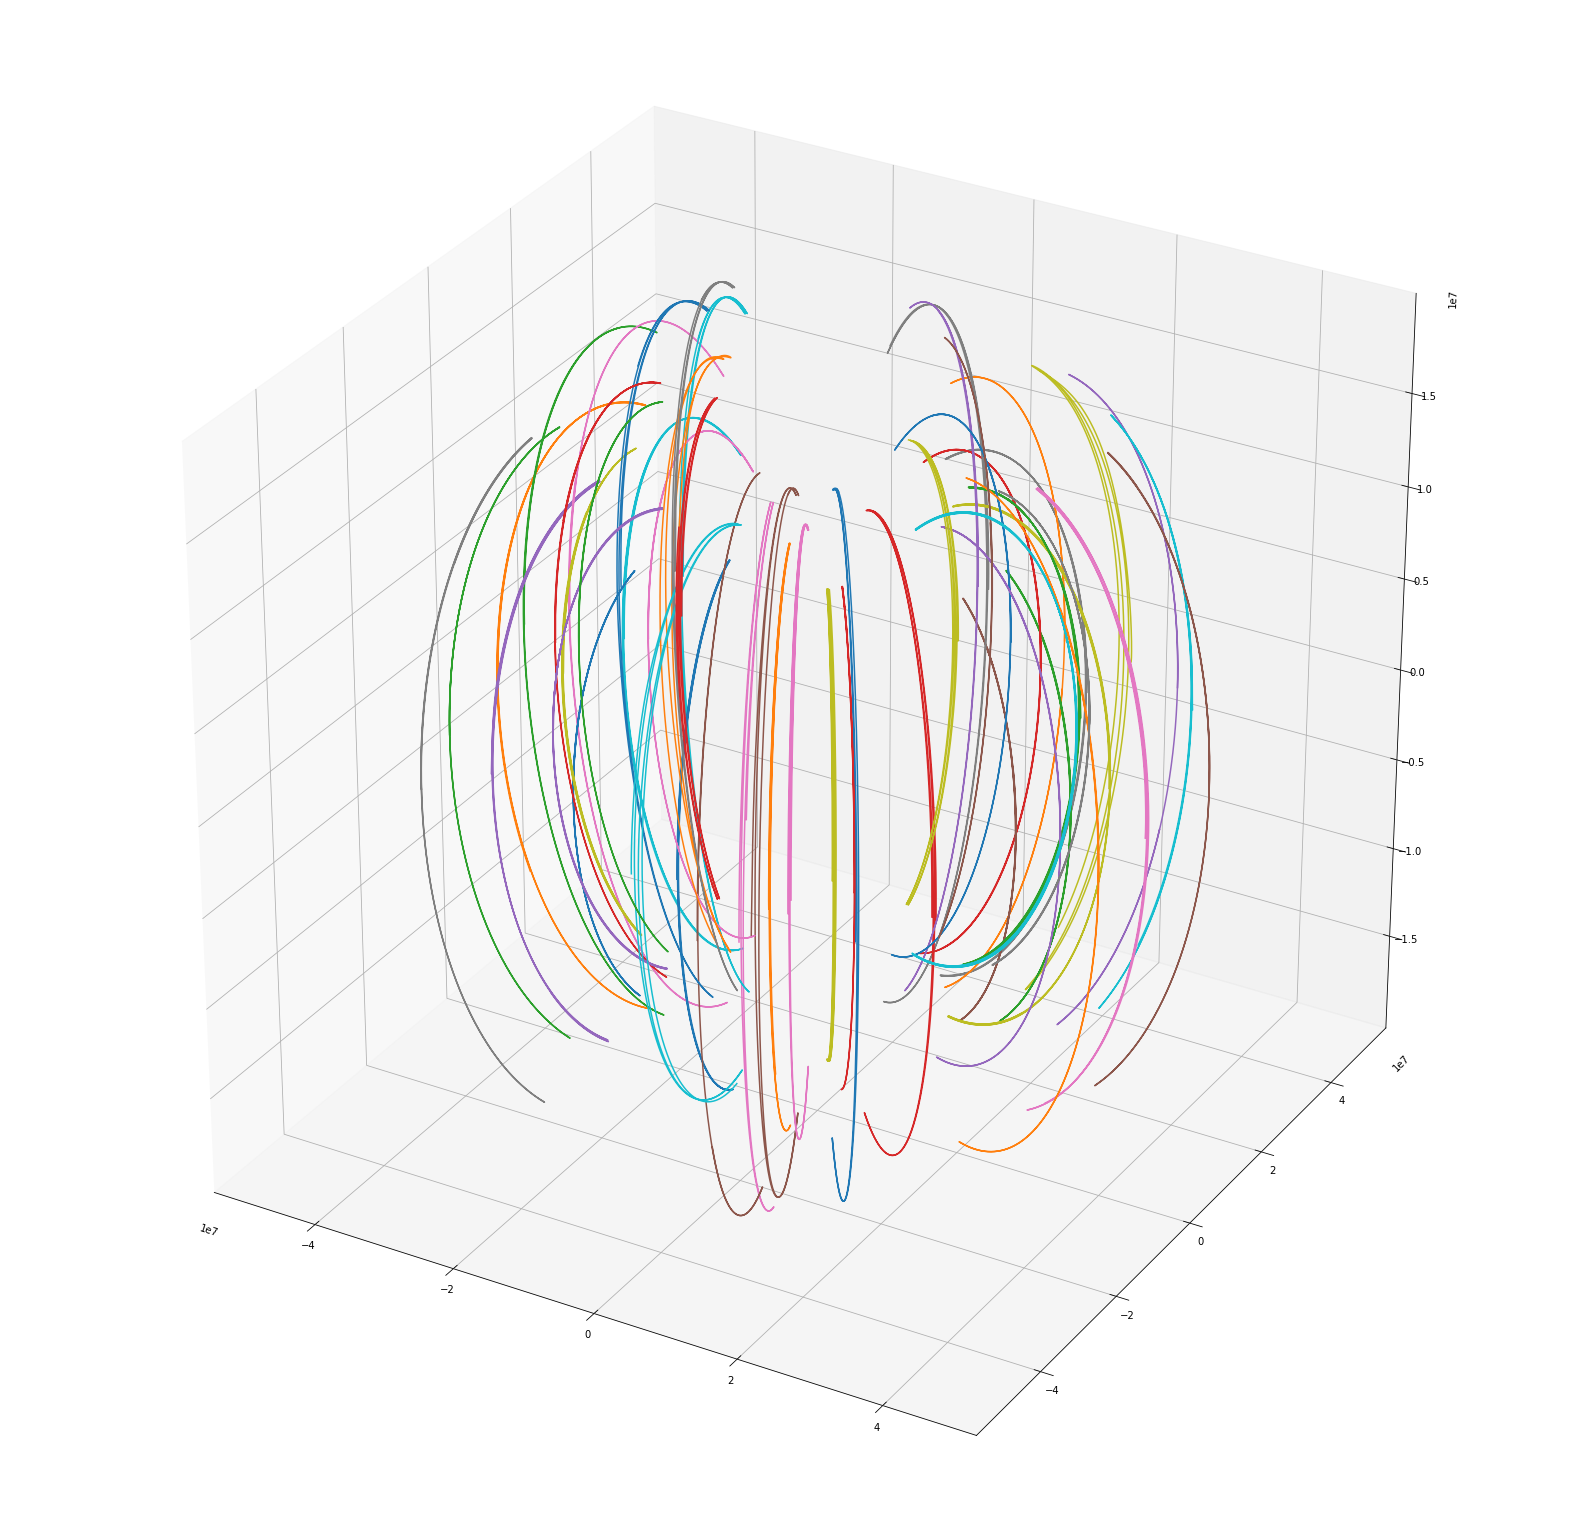

In [3]:
e_field = zero_field()
b_field = earth_dipole_axis_aligned()
solve   = solver(relativistic_boris(e_field, b_field))

T      = 1           # Total time (in seconds)
dt     = 1e-4        # Simulation time step
trials = 50          # Number of runs
steps  = int(T / dt) # Number of steps per run

history   = np.zeros((trials, steps, 4, 3)) # Particle, time slice, parameter (r, v, B, E), dimension
intrinsic = np.zeros((trials, 2))           # Particle, time slice, parameter (m, q)
    
# --------- #    

@njit
def gca_pos_mag(gca):
    history_new = np.zeros(len(gca[:, 0]))

    for i in range(len(gca[:, 0])):
        history_new[i] = np.sqrt(dot(gca[i], gca[i]))
    
    return history_new

def B_max(gca, B):
    z = gca[:, 2]
    
    # Find the local extrema of the z-path traced by the guiding center
    indices = np.argwhere(np.r_[True, z[1:] < z[:-1]] & np.r_[z[:-1] < z[1:], True] == True)[:, 0]
    
    # Find the magnitude of the magnetic field at the bounce points. This is where the particle is closest to the origin
    gca_mag = gca_pos_mag(gca)
    index = np.argwhere(gca_mag == np.amin(gca_mag))[:, 0][0]
    
    return np.linalg.norm(B(gca[index]))
    
def B_min(gca, B):
    z = gca[:, 2]
    
    # Find the indices marking the zero crossings of the guiding center trajectory
    z_sign = np.sign(z)
    rolled_z = np.roll(z_sign, 1) - z_sign
    
    # Remove the first crossing (usually anomalous)
    rolled_z[0] = 0
    indices = np.argwhere(rolled_z != 0)[:, 0]

    # Track the magnitude of the magnetic field at the equatorial plane via linear interpolation
    positions = []
    for i in indices:
        t = -gca[i - 1, 2] * dt / (gca[i, 2] - gca[i - 1, 2])
        positions.append((gca[i, :] - gca[i - 1, :]) / dt * t + gca[i - 1, :])
    B_min = [np.linalg.norm(B(r)) for r in positions]
    
    # Average over the values
    return np.sum(B_min) / len(B_min)

def loss_cone_from_B(B_min, B_max):
    return np.degrees(np.arcsin(np.sqrt(B_min / B_max)))

analytical_loss_cone_rel = np.zeros(trials)

# --------- #

r_dist         = uniform_ring(5 * Re, 8 * Re)
K_dist         = uniform_oom(5, 7)
pitch_ang_dist = uniform(np.pi / 12, np.pi / 4)
phase_ang_dist = uniform(0, 2 * np.pi)

for i in range(trials):
    r = r_dist()
    K = K_dist()
    
    history[i, 0, 0] = r
    history[i, 0, 1] = velocity_vec(r, K, sp.m_e, b_field, pitch_ang_dist(), phase_ang_dist())
    history[i, 0, 2] = b_field(r)
    history[i, 0, 3] = e_field(r)
    intrinsic[i, 0]  = sp.m_e
    intrinsic[i, 1]  = -sp.e
        
solve(history, intrinsic, dt)

plot_traj(history)

guiding_center = gca_filter(history, intrinsic, dt)
plot_gca(guiding_center)

# --------- #   

eq_pas = eq_pitch_angle(history)
numerical_loss_cone_rel = np.zeros(trials)

for i in range(trials):
    numerical_loss_cone_rel[i]  = np.mean(eq_pas[i, np.nonzero(eq_pas[i, :])])
    analytical_loss_cone_rel[i] = loss_cone_from_B(B_min(guiding_center[i], b_field), B_max(guiding_center[i], b_field))

In [4]:
# Relativistic loss cone results
error = to_percent(numerical_loss_cone_rel, analytical_loss_cone_rel)

# print('Error (%): ' + ' '.join(f'{x:.2f}\n' for x in error))
print(f'Average Error (%): {np.mean(error):.2f}')

Average Error (%): 0.21


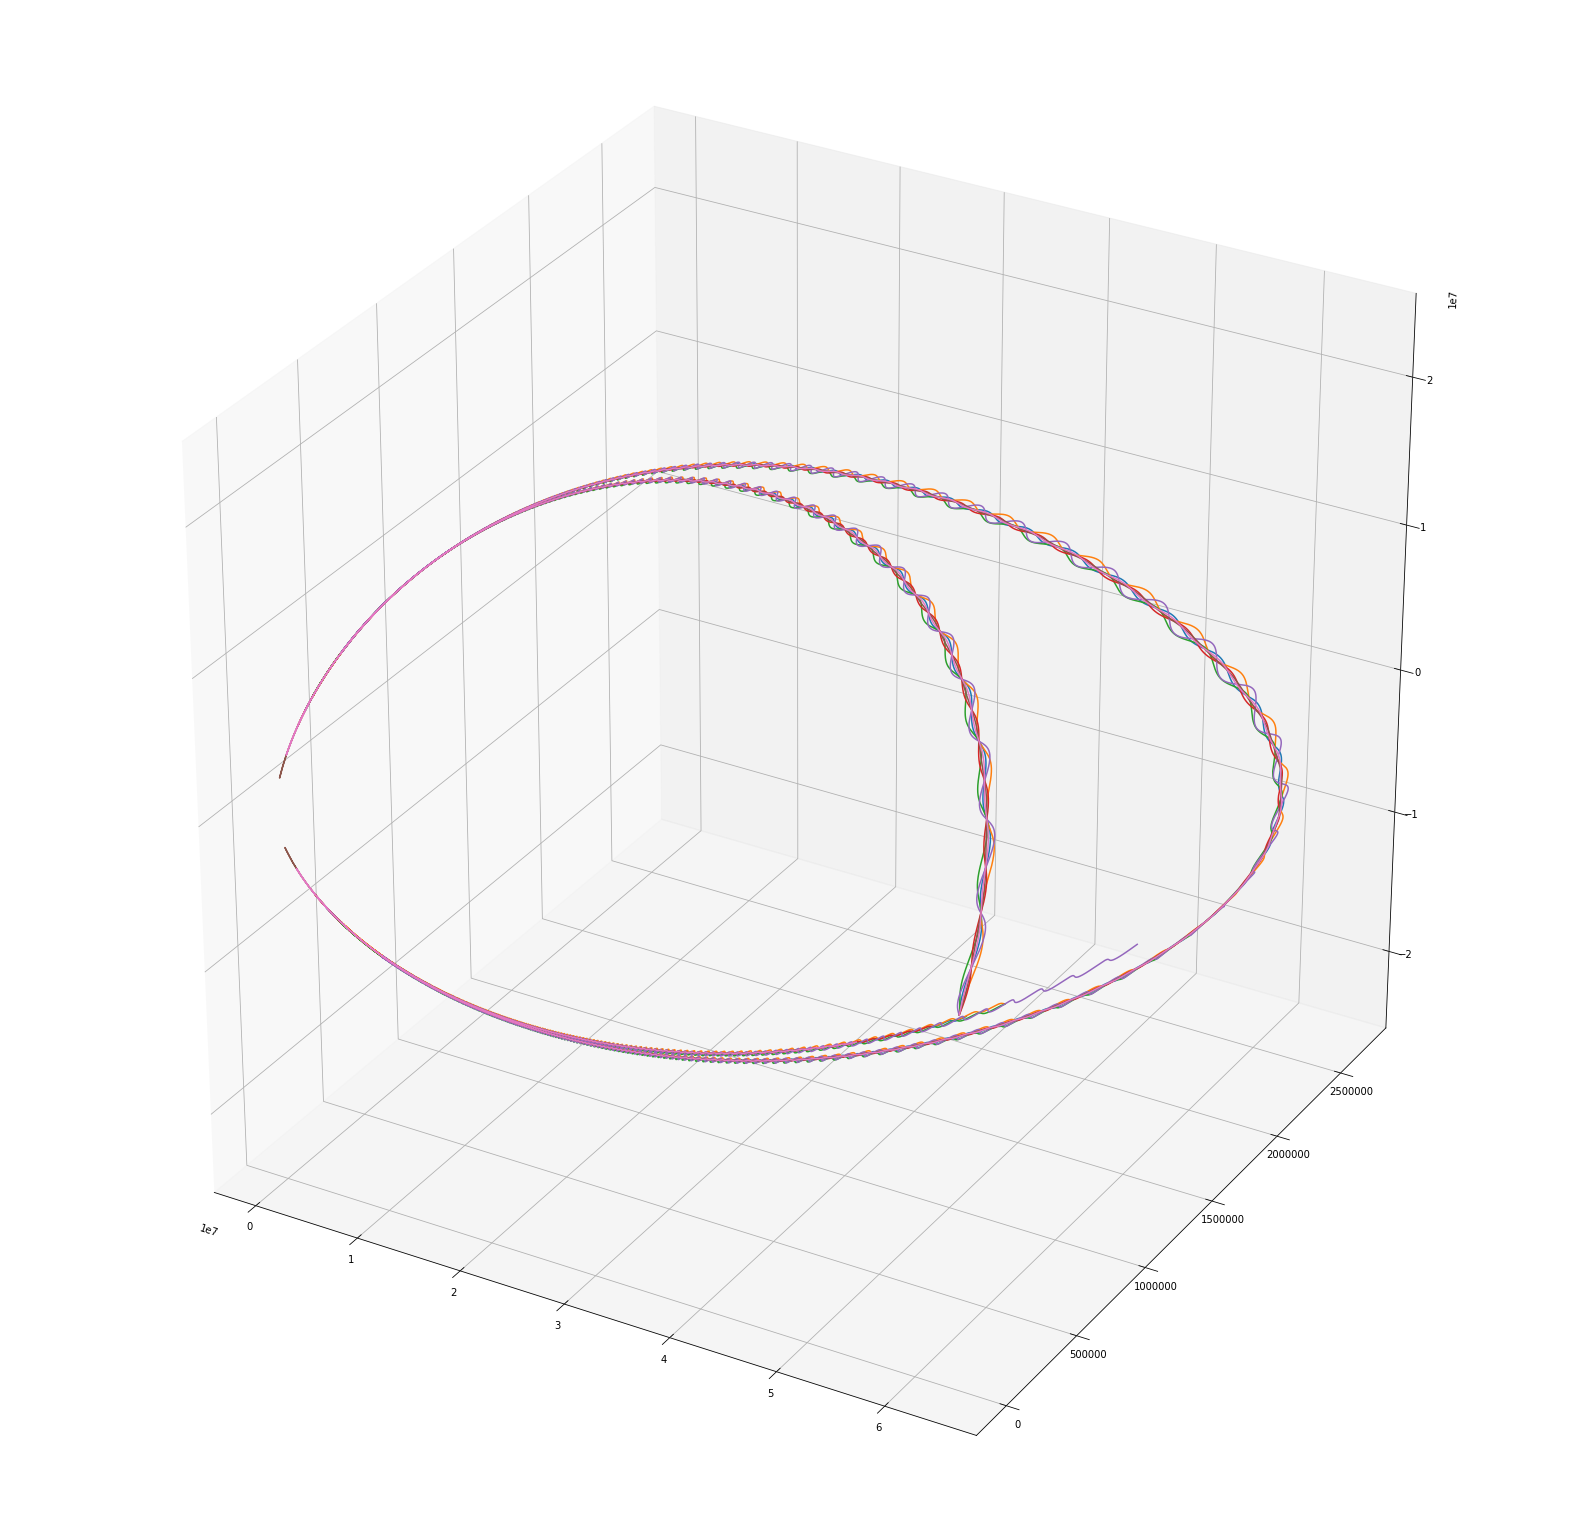

In [15]:
e_field = zero_field()
b_field = earth_dipole_axis_aligned()
solve   = solver(relativistic_boris(e_field, b_field))

T      = 1           # Total time (in seconds)
dt     = 1e-4        # Simulation time step
trials = 7           # Number of runs
steps  = int(T / dt) # Number of steps per run

history   = np.zeros((trials, steps, 4, 3)) # Particle, time slice, parameter (r, v, B, E), dimension
intrinsic = np.zeros((trials, 2))           # Particle, time slice, parameter (m, q)
    
# --------- #    

test_set = np.empty((trials, 3))
test_set[0] = np.array([0.5, -90., False])
test_set[1] = np.array([2.,  -150., False])
test_set[2] = np.array([2.,  -30.,  False])
test_set[3] = np.array([3.5, -90.,  False])
test_set[4] = np.array([1.5,  90.,  False])
test_set[5] = np.array([2.5, -90.,  True])
test_set[6] = np.array([1.5, -90.,  True])

# --------- #

r_dist = delta(np.array([10. * Re, 0., 0.]))
K_dist = delta(7e6)

for i in range(trials):
    r = r_dist()
    K = K_dist()
    
    history[i, 0, 0] = r
    history[i, 0, 1] = velocity_vec(r, K, sp.m_e, b_field, np.radians(test_set[i][0]), np.radians(test_set[i][1]))
    history[i, 0, 2] = b_field(r)
    history[i, 0, 3] = e_field(r)
    intrinsic[i, 0]  = sp.m_e
    intrinsic[i, 1]  = -sp.e
        
solve(history, intrinsic, dt)

plot_traj(history)

# --------- #

results = np.zeros(trials, dtype=np.bool)
pos_mag = position_mag(history)

for i in range(trials):
    if np.amin(pos_mag[i]) <= Re:
        results[i] = True

In [17]:
# Relativistic loss cone dependence on phase angle results
error = np.sum(results != test_set[:, 2]) / trials

# print('Error (%): ' + ' '.join(f'{x:.2f}\n' for x in error))
print(f'Average Error (%): {error:.2f}')

Average Error (%): 0.00


### Models of Earth's Magnetic Field

We use the Tsyganenko models of Earth's external magnetic field combined with the internal field provided by the IGRF model.

Model of Earth's magnetic field consisting of a superposition of the Tsyganenko 1989 model (DOI: 10.1016/0032-0633(89)90066-4) and the IGRF model.

    Args:
    Kp (int): A mapping to the Kp geomagnetic activity index. Acceptable values range from 1 to 7, mapping to values between 0 and 10, inclusive.
    


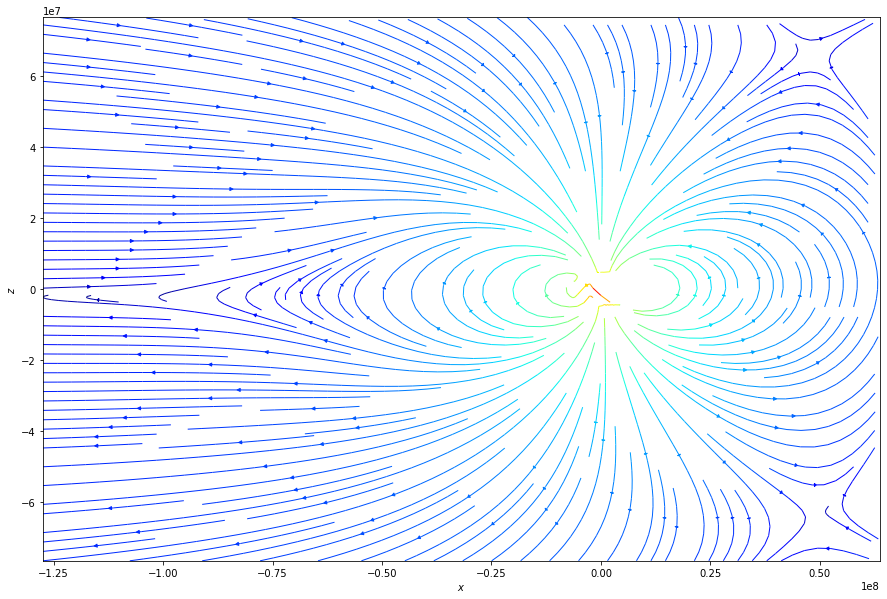

In [2]:
t89_test = t89(1)
print(t89.__doc__)

plot_field(t89_test, 'y', 50, [-20 * Re, 10 * Re], [-12 * Re, 12 * Re], (15, 10))

### Example of Pitch Angle Scattering

A clear example of pitch angle scattering can be seen with energetic electrons in the magnetotail of the T89 model. Particles passing through this region of significant field line curvature effectively feel an alteration of their equatorial pitch angle. Each brief transition to nonadiabaticity in the equatorial plane can be modeled as a scattering process. If a particle is scattered into its loss cone (a value less than a few degrees), it will precipitate into the Earth's atmosphere.

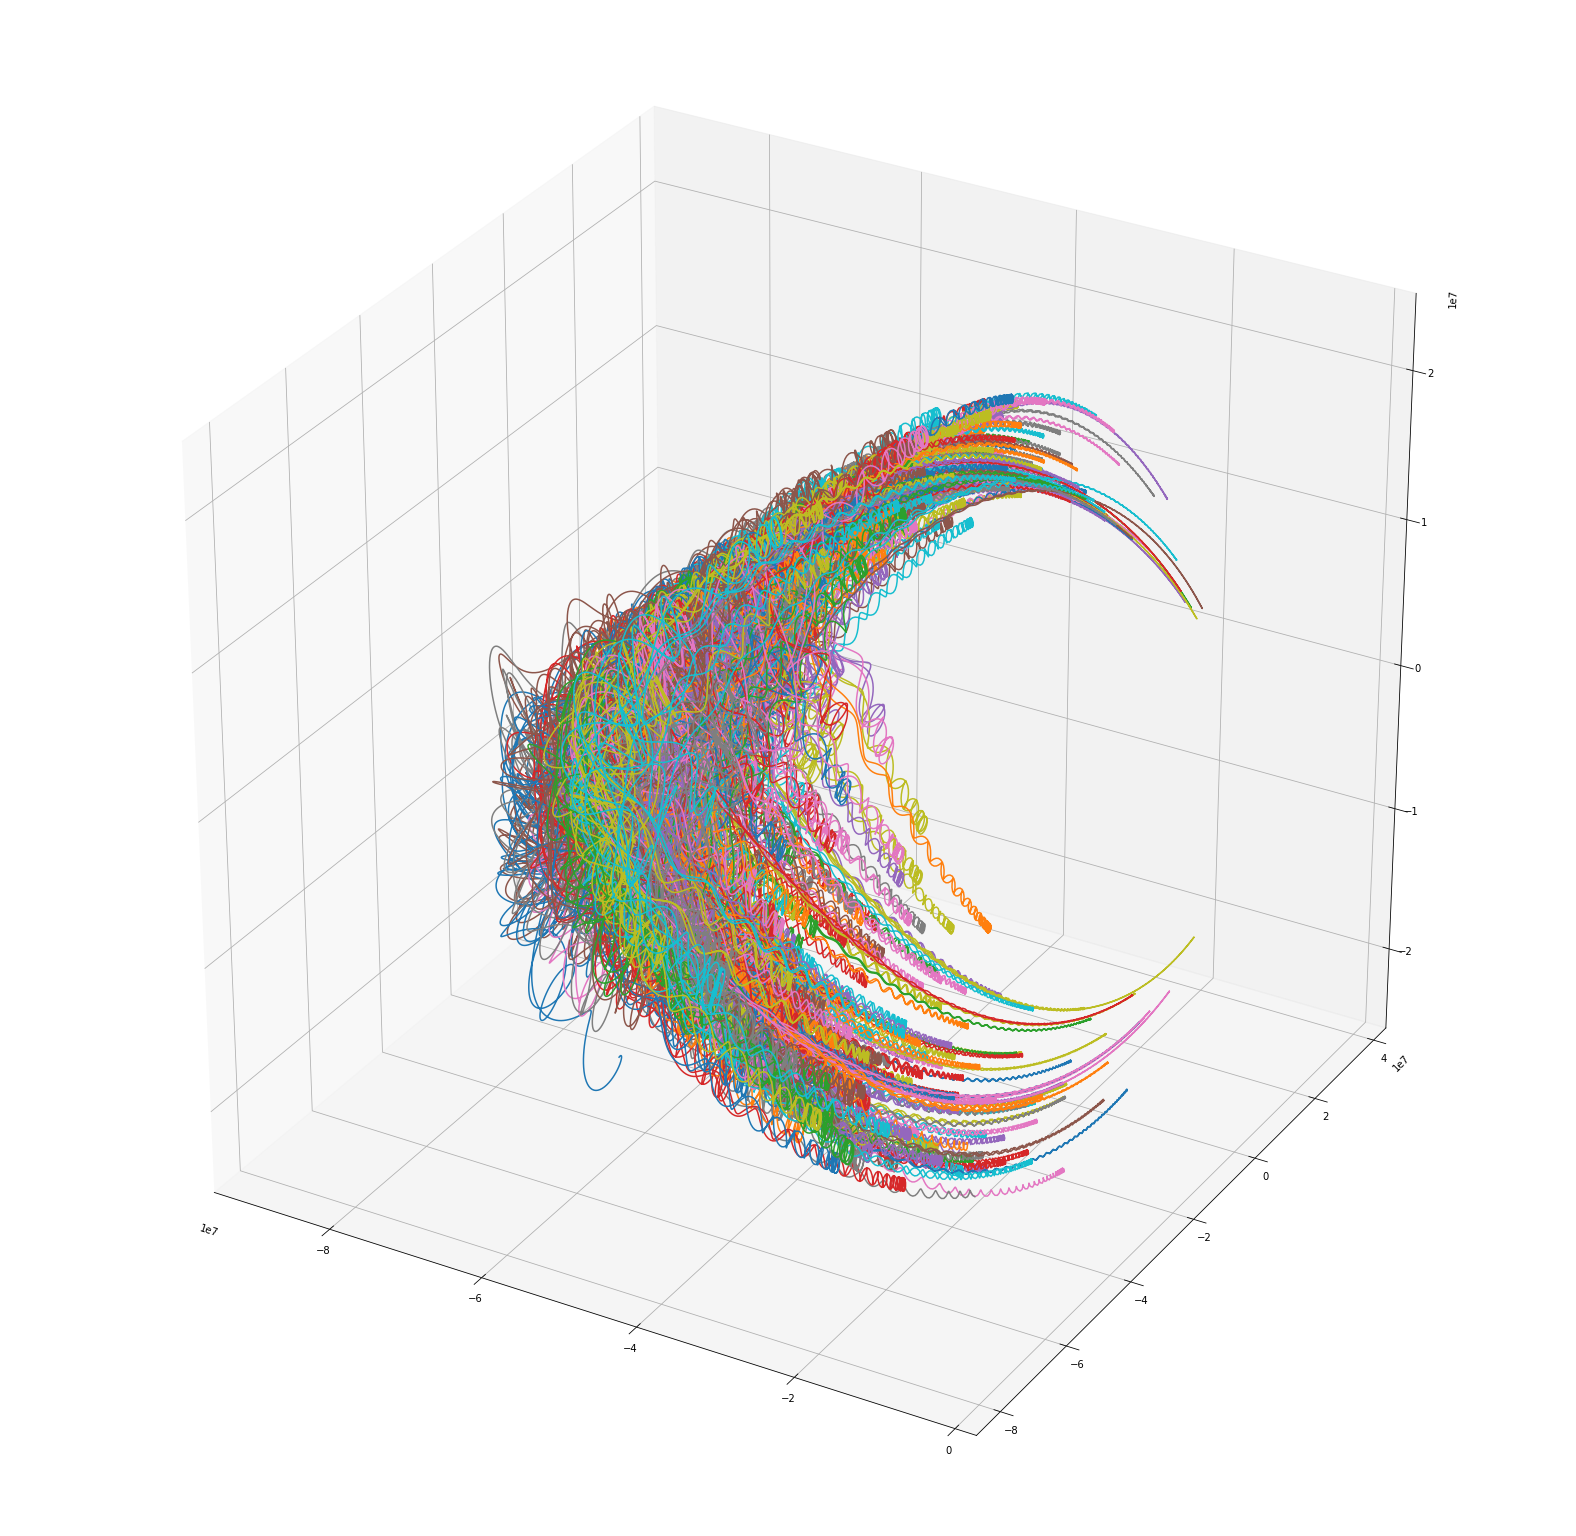

In [3]:
e_field = zero_field()
b_field = t89(1)
solve   = solver(relativistic_boris(e_field, b_field))

T      = 4           # Total time (in seconds)
dt     = 1e-3        # Simulation time step
trials = 100         # Number of runs
steps  = int(T / dt) # Number of steps per run

history, intrinsic = populate(trials,
                              steps,
                              e_field,
                              b_field,
                              uniform_partial_ring(11 * Re, 12 * Re, 5 * np.pi / 6, 7 * np.pi / 6),
                              delta(1e7),
                              delta(np.pi / 8),
                              uniform(0, 2 * np.pi)
                             )

solve(history, intrinsic, dt)

plot_traj(history)

### Visualizing Results

Examples of possibly useful visualizations are below.

The first shows the clear violation of the first adiabatic invariant upon entry into the current sheet.

The second is useful in the adiabatic regime, but is less useful in the given example. It would be preferable to examine the adiabatic and nonadiabatic regimes of each particle separately.

The third shows the evolution of the equatorial pitch angle distribution for successive equatorial crossings.

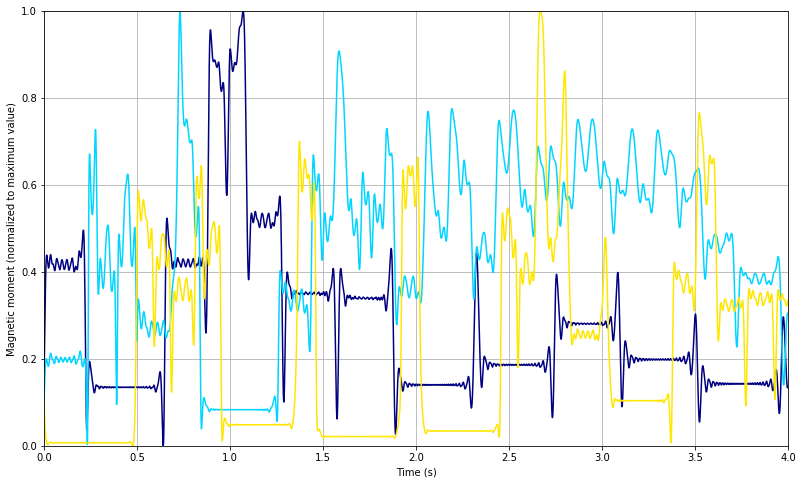

In [4]:
moments = magnetic_moment(history, intrinsic)

index_list = np.arange(0, steps) * dt

starting_trajectory = 15
num_trajectories = 3

fig = plt.figure(figsize = plt.figaspect(0.6) * 2)

for i in np.arange(starting_trajectory, starting_trajectory + num_trajectories):
    plt.plot(index_list, moments[i] / np.amax(moments[i]), color=plt.cm.jet((i - starting_trajectory) / float(num_trajectories)))

plt.xlabel('Time (s)')
plt.ylabel('Magnetic moment (normalized to maximum value)')

plt.xlim([0., 4.])
plt.ylim([0., 1.])

plt.grid()
plt.show()

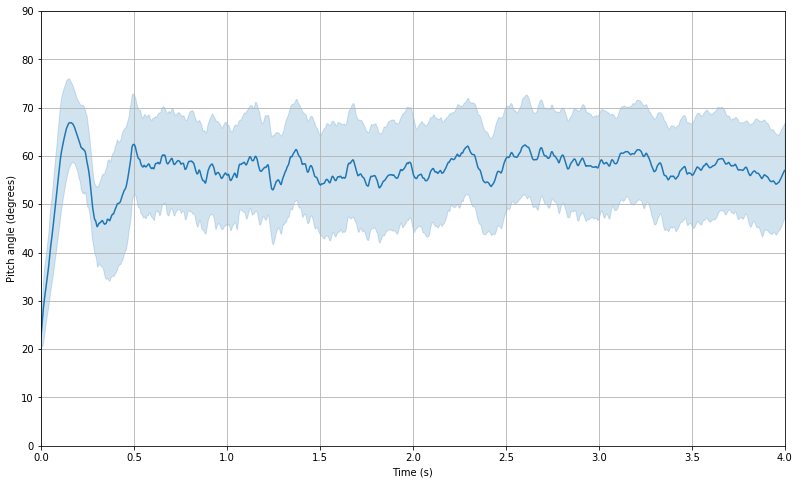

In [12]:
pitch_angle_composite = pitch_angle(history)

pitch_angle_mean = np.mean(pitch_angle_composite, axis=0)
pitch_angle_std_dev = np.std(pitch_angle_composite, axis=0)

lower_std_dev = np.array(pitch_angle_mean - pitch_angle_std_dev * 0.5)
upper_std_dev = np.array(pitch_angle_mean + pitch_angle_std_dev * 0.5)

index_list = np.arange(0, steps) * dt

fig = plt.figure(figsize = plt.figaspect(0.6) * 2)

plt.plot(index_list, pitch_angle_mean, color='C0')
plt.fill_between(index_list, lower_std_dev, upper_std_dev, color='C0', alpha=0.2)

plt.xlabel('Time (s)')
plt.ylabel('Pitch angle (degrees)')

plt.xlim([0., 4])
plt.ylim([0., 90.])

plt.grid()
plt.show()

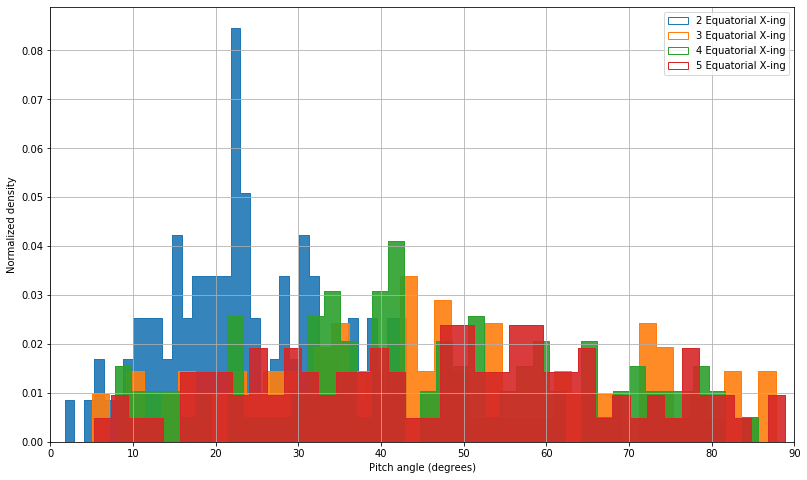

In [51]:
eq_pas = eq_pitch_angle(history)

fig = plt.figure(figsize = plt.figaspect(0.6) * 2)
        
for i in np.arange(1, 5):
    plt.hist(eq_pas[:, i], label=f'{i+1} Equatorial X-ing', histtype='step', color=f'C{i - 1}', bins=40, density=True)
    plt.hist(eq_pas[:, i], histtype='stepfilled', alpha=0.9, color=f'C{i - 1}', bins=40, density=True)

plt.xlabel('Pitch angle (degrees)')
plt.ylabel('Normalized density')
plt.legend()

plt.xlim([0., 90.])

plt.grid()
plt.show()

### Example of Pitch Angle Diffusion

A major factor contributing to pitch angle diffusion is the phase angle, as demonstrated below and detailed in https://doi.org/10.1029/JA089iA05p02699. Small differences in this parameter lead to a divergence in pitch angles over time.

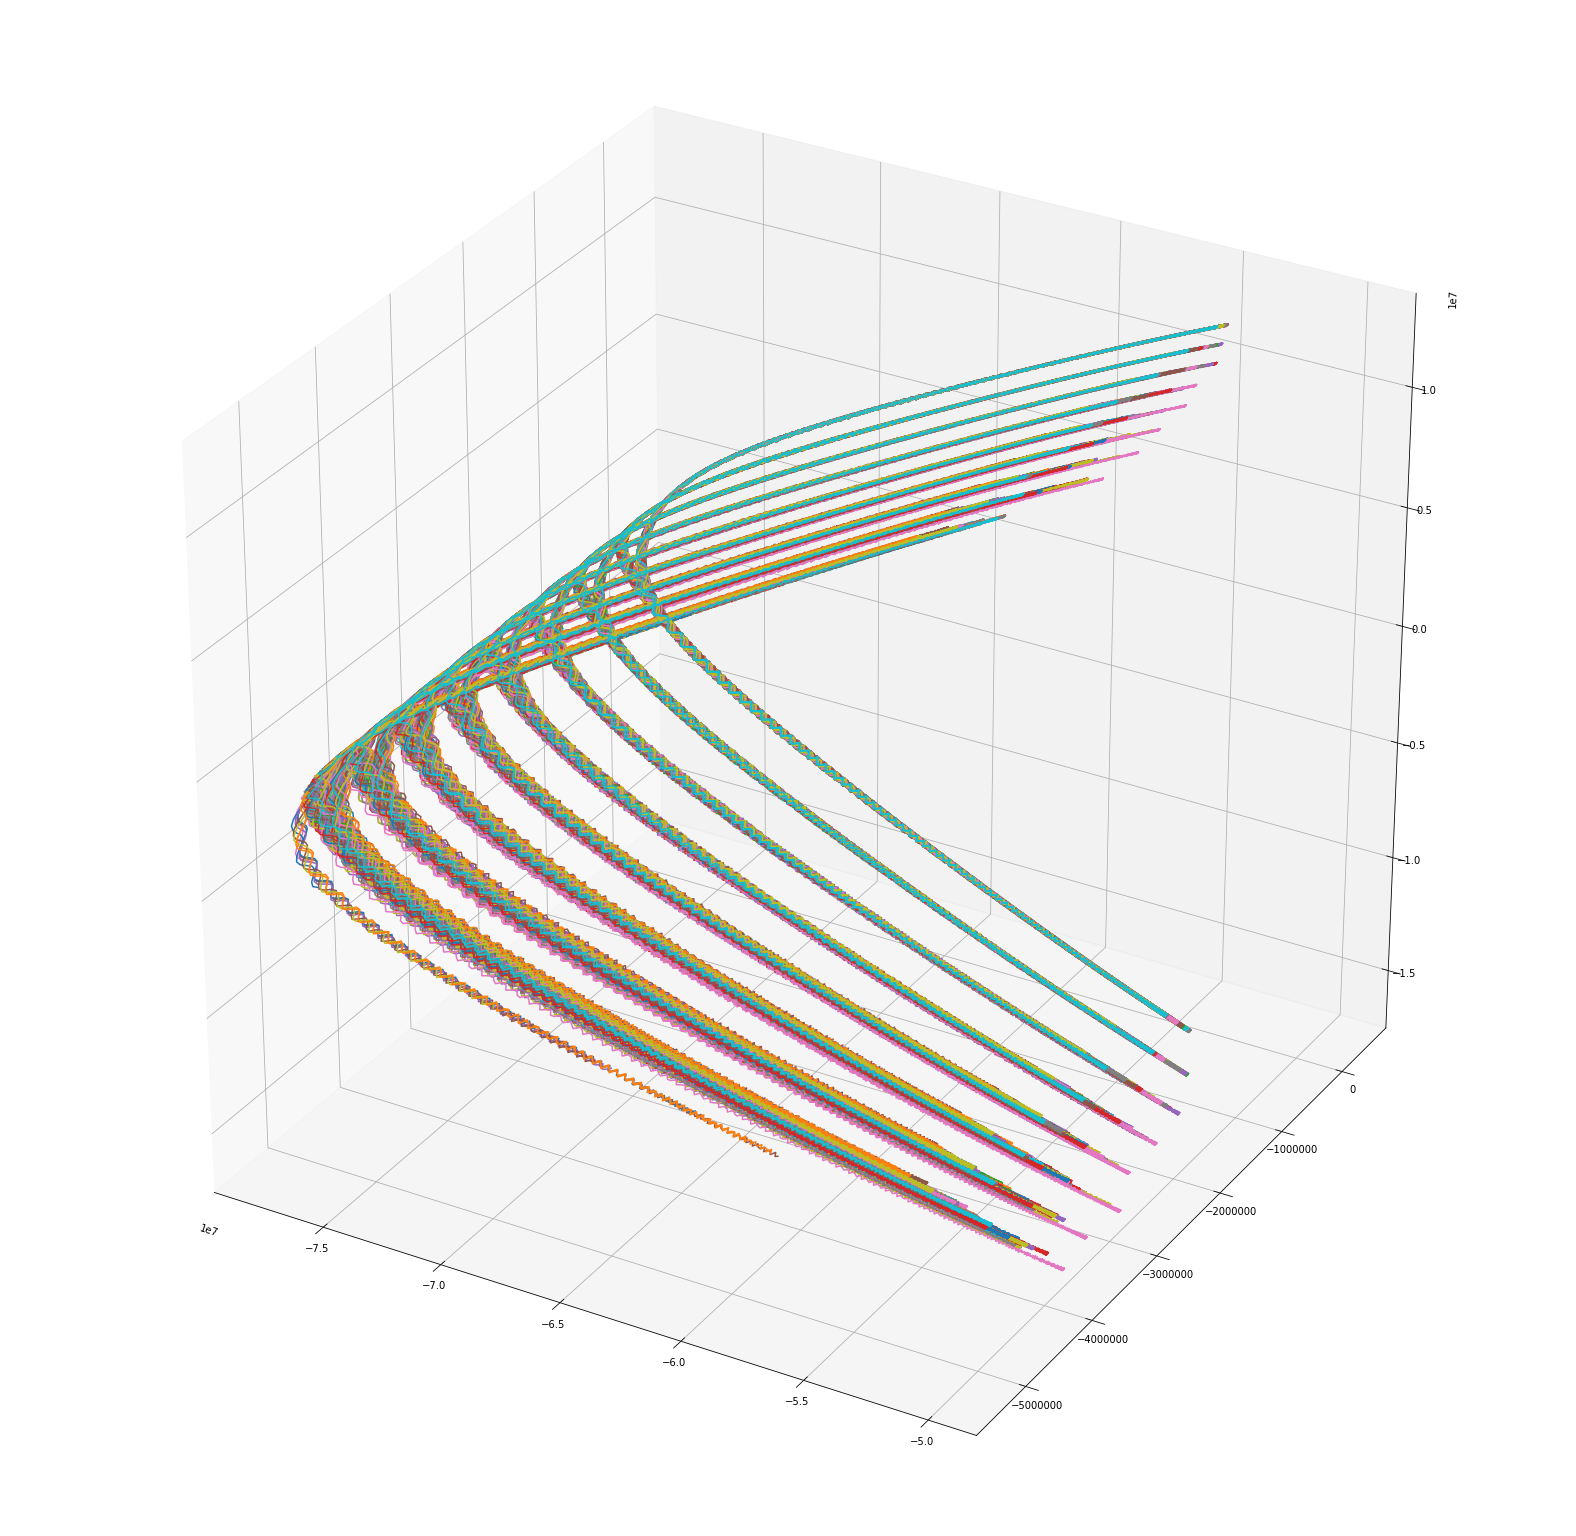

In [56]:
e_field = zero_field()
b_field = t89(1)
solve   = solver(relativistic_boris(e_field, b_field))

T      = 10          # Total time (in seconds)
dt     = 1e-3        # Simulation time step
trials = 100         # Number of runs
steps  = int(T / dt) # Number of steps per run

history, intrinsic = populate(trials,
                              steps,
                              e_field,
                              b_field,
                              delta(np.array([-12 * Re, 0., 0.])),
                              delta(1e5),
                              delta(np.pi / 8),
                              uniform(0, np.pi / 8)
                             )

solve(history, intrinsic, dt)

plot_traj(history)

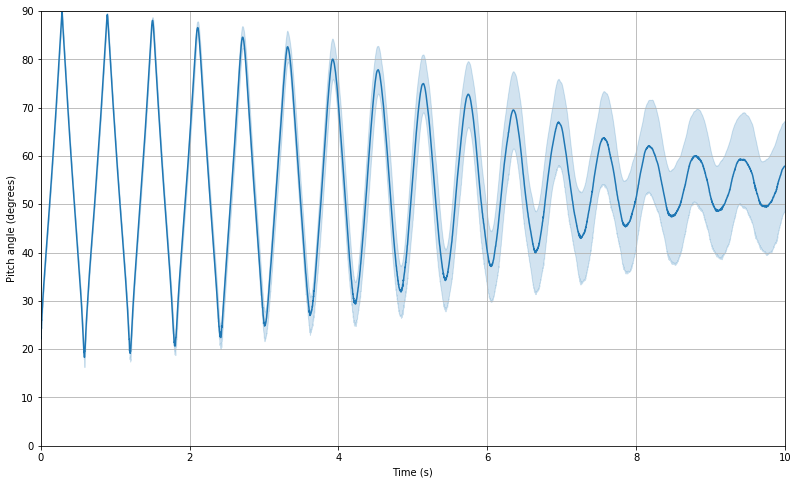

In [57]:
pitch_angle_composite = pitch_angle(history)

pitch_angle_mean = np.mean(pitch_angle_composite, axis=0).flatten()
pitch_angle_std_dev = np.std(pitch_angle_composite, axis=0).flatten()

lower_std_dev = np.array(pitch_angle_mean - pitch_angle_std_dev * 0.5)
upper_std_dev = np.array(pitch_angle_mean + pitch_angle_std_dev * 0.5)

index_list = np.arange(0, steps) * dt

fig = plt.figure(figsize = plt.figaspect(0.6) * 2)

plt.plot(index_list, pitch_angle_mean, color='C0')
plt.fill_between(index_list, lower_std_dev, upper_std_dev, color='C0', alpha=0.2)

plt.xlabel('Time (s)')
plt.ylabel('Pitch angle (degrees)')

plt.xlim([0., 10.])
plt.ylim([0., 90.])

plt.grid()
plt.show()

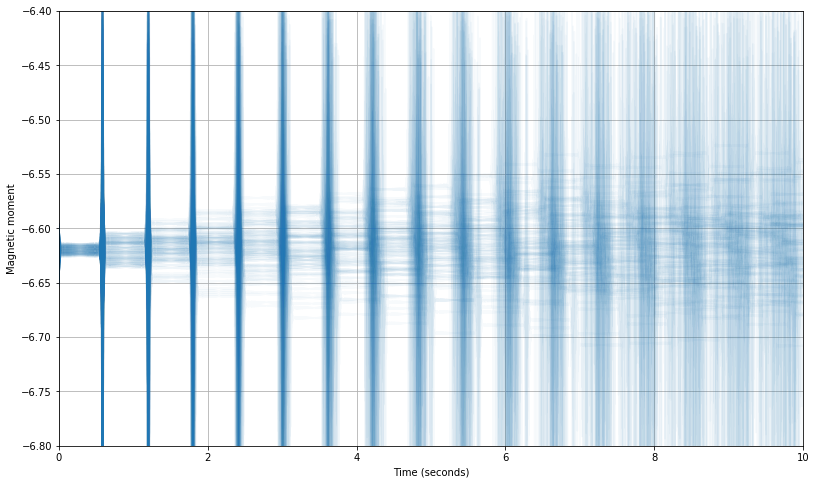

In [62]:
moments = magnetic_moment(history, intrinsic)

fig = plt.figure(figsize = plt.figaspect(0.6) * 2)

index_list = np.arange(0, steps) * dt

for i in range(trials):
    plt.plot(index_list, np.log10(moments[i]), alpha=(1 / 30.), color='C0')
    
plt.xlim(0, 10)
plt.ylim(-6.8, -6.4)
plt.grid()

plt.xlabel('Time (seconds)')
plt.ylabel('Magnetic moment')

plt.show()